# 异常检测引擎相关实验

## F1计算函数

In [82]:
def calculate_f1(precision, recall):
    # 计算 F1 分数
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f1_score)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [102]:
calculate_f1(0.83,0.62)

0.7097931034482758


## 数据异常占比

In [103]:
file_path = "command.data"

In [104]:
import numpy as np
# 读取数据
labels = []
with open(file_path, "r") as file:
    for line in file:
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 计算0和1的比例
count = np.bincount(labels)
total = len(labels)

# 计算比例并打印
ratio_0 = count[0] / total
ratio_1 = count[1] / total

print(f"0的比例: {ratio_0:.2f}")
print(f"1的比例: {ratio_1:.2f}")


0的比例: 0.90
1的比例: 0.10


# 一、孤立森林算法加权PR曲线对比

### （0）用原始命令行的IForest

Column 0: dtype=<U513
Column 1: dtype=<U513
Column 2: dtype=<U513
Column 3: dtype=<U513
Column 4: dtype=<U513
Column 5: dtype=<U513
Data type after conversion: float64
Contamination=0.05:
  Recall (TPR) = 0.30
  Precision = 0.63
  FPR = 0.02
  F1 Score = 0.41
  Accuracy = 0.91
  AUC-PR = 0.38
------------------------------


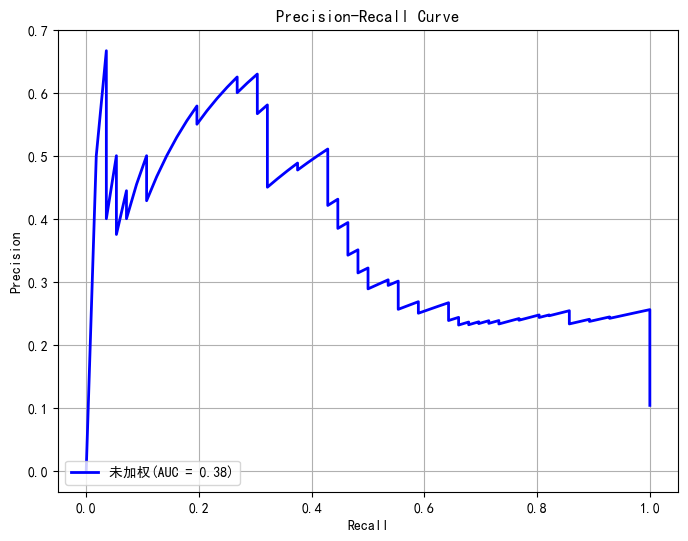

In [105]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 设置不同的 contamination 值
contamination_values = [0.05]

# 不加权的孤立森林模型
for contamination in contamination_values:
    # 创建并训练孤立森林模型
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(data)  # 现在所有数据已经是数值型了，能成功进行训练
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 计算 F1 Score
    f1 = f1_score(labels, predictions)

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 异常分数越高，表示越可能是异常

    # 计算PR曲线和AUC-PR
    precision_list_1, recall_list_1, auc_pr_1 = get_pr(anomaly_scores, np.array(labels))

    # 计算Accuracy
    accuracy = accuracy_score(labels, predictions)

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  F1 Score = {f1:.2f}")
    print(f"  Accuracy = {accuracy:.2f}")
    print(f"  AUC-PR = {auc_pr_1:.2f}")
    print("-" * 30)

    plt.rcParams['font.family']='SimHei'
    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_1, precision_list_1, color='blue', lw=2, label=f'未加权(AUC = {auc_pr_1:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


### （1）没有加权的IForest，用意图：

Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
Contamination=0.05:
  Recall (TPR) = 0.20
  Precision = 0.41
  FPR = 0.03
  F1 Score = 0.27
  Accuracy = 0.89
  AUC-PR = 0.33
------------------------------


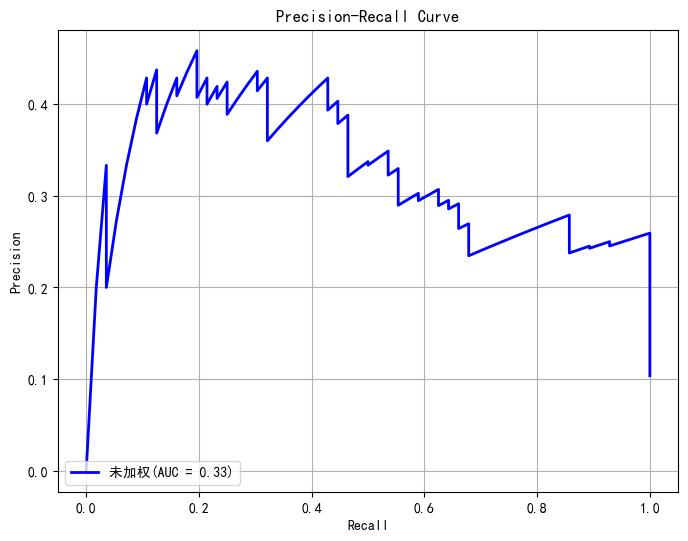

In [107]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 设置不同的 contamination 值
contamination_values = [0.05]

# 不加权的孤立森林模型
for contamination in contamination_values:
    # 创建并训练孤立森林模型
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(data)  # 现在所有数据已经是数值型了，能成功进行训练
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 计算 F1 Score
    f1 = f1_score(labels, predictions)

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 异常分数越高，表示越可能是异常

    # 计算PR曲线和AUC-PR
    precision_list_1, recall_list_1, auc_pr_1 = get_pr(anomaly_scores, np.array(labels))

    # 计算Accuracy
    accuracy = accuracy_score(labels, predictions)

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  F1 Score = {f1:.2f}")
    print(f"  Accuracy = {accuracy:.2f}")
    print(f"  AUC-PR = {auc_pr_1:.2f}")
    print("-" * 30)

    plt.rcParams['font.family']='SimHei'
    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_1, precision_list_1, color='blue', lw=2, label=f'未加权(AUC = {auc_pr_1:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


### （2）加权之后的IF：

Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
[[0.00000000e+00 0.00000000e+00 1.70000000e+01 0.00000000e+00
  1.00000000e+01 1.10000000e+01]
 [0.00000000e+00 2.77885101e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 5.55770112e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 8.33655213e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 3.05673584e-05 1.70000000e+01 0.00000000e+00
  1.30000000e+01 1.40000000e+01]]
Contamination=0.05:
  Recall (TPR) = 0.45
  Precision = 0.83
  FPR = 0.01
  F1 Score = 0.58
  Accuracy = 0.93
  AUC-PR = 0.55
------------------------------


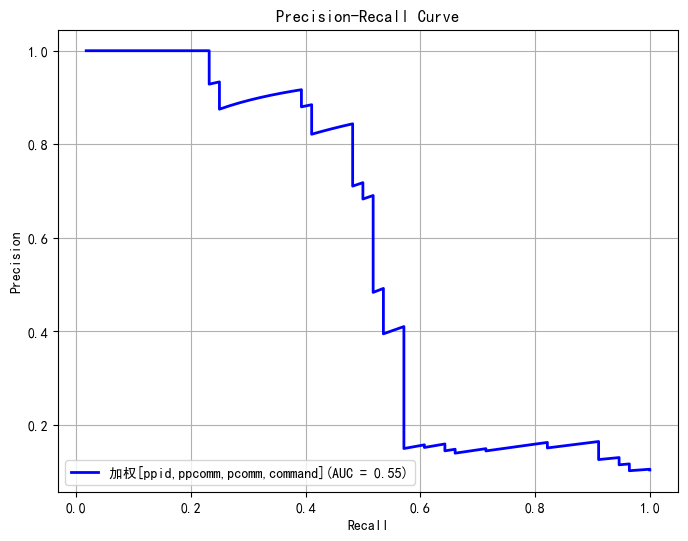

In [108]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 假设我们给每个特征一个不同的权重，以下是一个简单的例子
weighted_features = np.array([1.0, 1.0, 2.0, 2.0, 2.0, 2.0])  # 各特征的权重

# 打印一下数据的部分内容，确认没有问题
print(data[:5])  # 打印前5行数据查看

# 设置不同的 contamination 值
contamination_values = [0.05]

# 自定义加权孤立森林模型
class WeightedIsolationForest(IsolationForest):
    def __init__(self, n_estimators=100, contamination='auto', max_samples='auto', random_state=None, weighted_features=None):
        super().__init__(n_estimators=n_estimators, contamination=contamination, max_samples=max_samples, random_state=random_state)
        self.weighted_features = weighted_features  # 用于存储每个特征的权重

    def fit(self, X, y=None):
        if self.weighted_features is not None:
            # 对数据应用特征权重
            weighted_X = X * self.weighted_features
        else:
            weighted_X = X
        return super().fit(weighted_X)

# 遍历不同的 contamination 值
for contamination in contamination_values:
    # 创建并训练加权孤立森林模型
    clf = WeightedIsolationForest(contamination=contamination, random_state=42, weighted_features=weighted_features)
    clf.fit(data)  # 现在所有数据已经是数值型了，能成功进行训练
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 计算 F1 Score
    f1 = f1_score(labels, predictions)

    # 计算Accuracy
    accuracy = accuracy_score(labels, predictions)

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 异常分数越高，表示越可能是异常

    # 计算PR曲线和AUC-PR
    precision_list_2, recall_list_2, auc_pr_2 = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  F1 Score = {f1:.2f}")
    print(f"  Accuracy = {accuracy:.2f}")
    print(f"  AUC-PR = {auc_pr_2:.2f}")
    print("-" * 30)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_2, precision_list_2, color='blue', lw=2, label=f'加权[ppid,ppcomm,pcomm,command](AUC = {auc_pr_2:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
[[0.00000000e+00 0.00000000e+00 1.70000000e+01 0.00000000e+00
  1.00000000e+01 1.10000000e+01]
 [0.00000000e+00 2.77885101e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 5.55770112e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 8.33655213e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 3.05673584e-05 1.70000000e+01 0.00000000e+00
  1.30000000e+01 1.40000000e+01]]
Contamination=0.05:
  Recall (TPR) = 0.46
  Precision = 0.48
  FPR = 0.03
  AUC-PR = 0.42
------------------------------


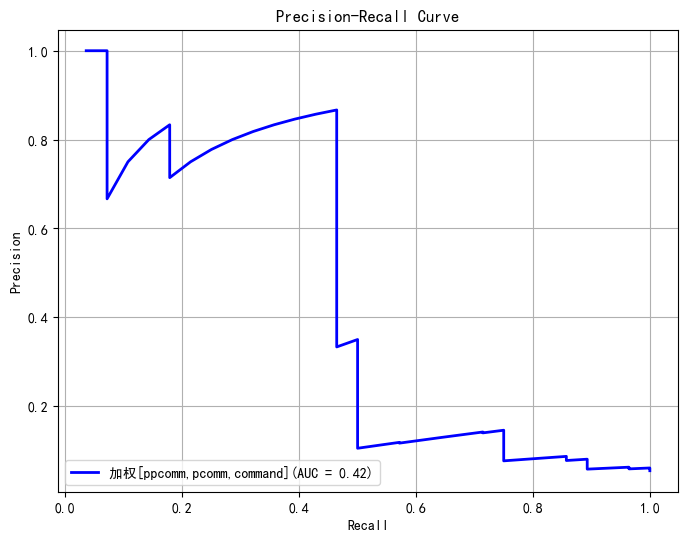

In [144]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 假设我们给每个特征一个不同的权重，以下是一个简单的例子
weighted_features = np.array([1.0, 1.0, 1.0, 2.0, 2.0, 2.0])  # 各特征的权重

# 打印一下数据的部分内容，确认没有问题
print(data[:5])  # 打印前5行数据查看

# 设置不同的 contamination 值
contamination_values = [0.05]

# 自定义加权孤立森林模型
class WeightedIsolationForest(IsolationForest):
    def __init__(self, n_estimators=100, contamination='auto', max_samples='auto', random_state=None, weighted_features=None):
        super().__init__(n_estimators=n_estimators, contamination=contamination, max_samples=max_samples, random_state=random_state)
        self.weighted_features = weighted_features  # 用于存储每个特征的权重

    def fit(self, X, y=None):
        if self.weighted_features is not None:
            # 对数据应用特征权重
            weighted_X = X * self.weighted_features
        else:
            weighted_X = X
        return super().fit(weighted_X)

# 遍历不同的 contamination 值
for contamination in contamination_values:
    # 创建并训练加权孤立森林模型
    clf = WeightedIsolationForest(contamination=contamination, random_state=42, weighted_features=weighted_features)
    clf.fit(data)  # 现在所有数据已经是数值型了，能成功进行训练
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 异常分数越高，表示越可能是异常

    # 计算PR曲线和AUC-PR
    precision_list_3, recall_list_3, auc_pr_3 = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  AUC-PR = {auc_pr_3:.2f}")
    print("-" * 30)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_3, precision_list_3, color='blue', lw=2, label=f'加权[ppcomm,pcomm,command](AUC = {auc_pr_3:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
[[0.00000000e+00 0.00000000e+00 1.70000000e+01 0.00000000e+00
  1.00000000e+01 1.10000000e+01]
 [0.00000000e+00 2.77885101e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 5.55770112e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 8.33655213e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 3.05673584e-05 1.70000000e+01 0.00000000e+00
  1.30000000e+01 1.40000000e+01]]
Contamination=0.05:
  Recall (TPR) = 0.36
  Precision = 0.50
  FPR = 0.02
  AUC-PR = 0.29
------------------------------


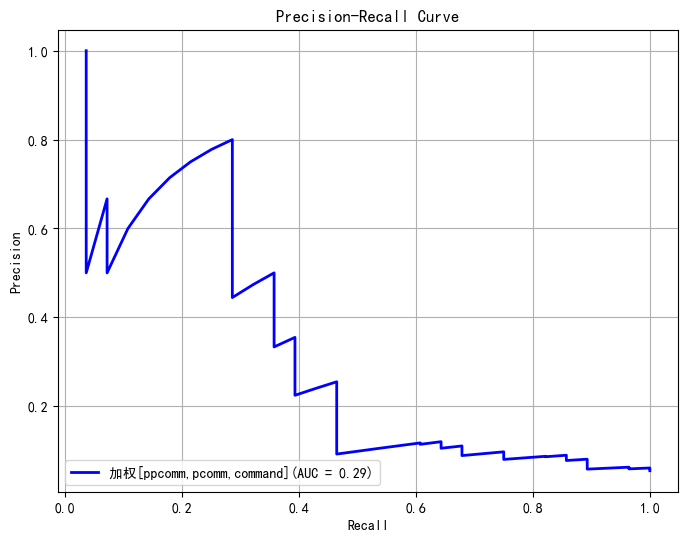

In [145]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 假设我们给每个特征一个不同的权重，以下是一个简单的例子
weighted_features = np.array([2.0, 1.0, 1.0, 2.0, 2.0, 2.0])  # 各特征的权重

# 打印一下数据的部分内容，确认没有问题
print(data[:5])  # 打印前5行数据查看

# 设置不同的 contamination 值
contamination_values = [0.05]

# 自定义加权孤立森林模型
class WeightedIsolationForest(IsolationForest):
    def __init__(self, n_estimators=100, contamination='auto', max_samples='auto', random_state=None, weighted_features=None):
        super().__init__(n_estimators=n_estimators, contamination=contamination, max_samples=max_samples, random_state=random_state)
        self.weighted_features = weighted_features  # 用于存储每个特征的权重

    def fit(self, X, y=None):
        if self.weighted_features is not None:
            # 对数据应用特征权重
            weighted_X = X * self.weighted_features
        else:
            weighted_X = X
        return super().fit(weighted_X)

# 遍历不同的 contamination 值
for contamination in contamination_values:
    # 创建并训练加权孤立森林模型
    clf = WeightedIsolationForest(contamination=contamination, random_state=42, weighted_features=weighted_features)
    clf.fit(data)  # 现在所有数据已经是数值型了，能成功进行训练
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 异常分数越高，表示越可能是异常

    # 计算PR曲线和AUC-PR
    precision_list_4, recall_list_4, auc_pr_4 = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  AUC-PR = {auc_pr_4:.2f}")
    print("-" * 30)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_4, precision_list_4, color='blue', lw=2, label=f'加权[ppcomm,pcomm,command](AUC = {auc_pr_4:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
[[0.00000000e+00 0.00000000e+00 1.70000000e+01 0.00000000e+00
  1.00000000e+01 1.10000000e+01]
 [0.00000000e+00 2.77885101e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 5.55770112e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 8.33655213e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 3.05673584e-05 1.70000000e+01 0.00000000e+00
  1.30000000e+01 1.40000000e+01]]
Contamination=0.2:
  Recall (TPR) = 0.86
  Precision = 0.08
  FPR = 0.60
  F1 Score = 0.14
  Accuracy = 0.43
  AUC-PR = 0.49
------------------------------


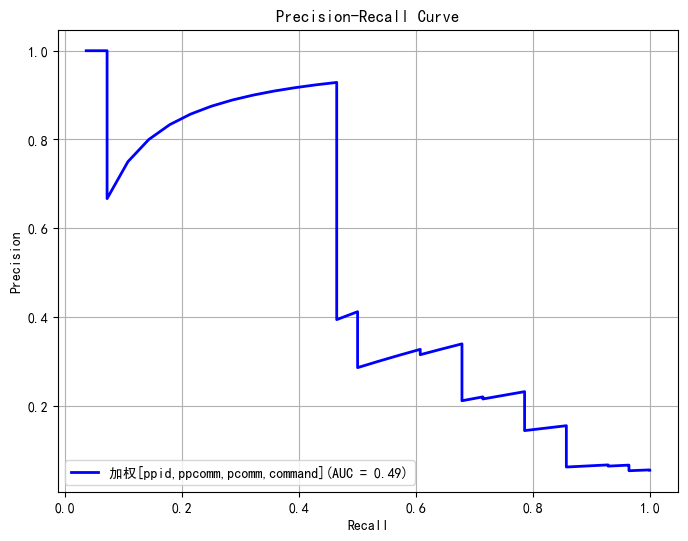

In [146]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 假设我们给每个特征一个不同的权重，以下是一个简单的例子
weighted_features = np.array([1.0, 1.0, 2.0, 2.0, 2.0, 2.0])  # 各特征的权重

# 打印一下数据的部分内容，确认没有问题
print(data[:5])  # 打印前5行数据查看

# 设置不同的 contamination 值
contamination_values = [0.2]

# 自定义加权孤立森林模型
class WeightedIsolationForest(IsolationForest):
    def __init__(self, n_estimators=100, contamination='auto', max_samples='auto', random_state=None, weighted_features=None):
        super().__init__(n_estimators=n_estimators, contamination=contamination, max_samples=max_samples, random_state=random_state)
        self.weighted_features = weighted_features  # 用于存储每个特征的权重

    def fit(self, X, y=None):
        if self.weighted_features is not None:
            # 对数据应用特征权重
            weighted_X = X * self.weighted_features
        else:
            weighted_X = X
        return super().fit(weighted_X)

# 遍历不同的 contamination 值
for contamination in contamination_values:
    # 创建并训练加权孤立森林模型
    clf = WeightedIsolationForest(contamination=contamination, random_state=42, weighted_features=weighted_features)
    clf.fit(data)  # 现在所有数据已经是数值型了，能成功进行训练
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 计算 F1 Score
    f1 = f1_score(labels, predictions)

    # 计算Accuracy
    accuracy = accuracy_score(labels, predictions)

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 异常分数越高，表示越可能是异常

    # 计算PR曲线和AUC-PR
    precision_list_2, recall_list_2, auc_pr_2 = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  F1 Score = {f1:.2f}")
    print(f"  Accuracy = {accuracy:.2f}")
    print(f"  AUC-PR = {auc_pr_2:.2f}")
    print("-" * 30)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_2, precision_list_2, color='blue', lw=2, label=f'加权[ppid,ppcomm,pcomm,command](AUC = {auc_pr_2:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
[[0.00000000e+00 0.00000000e+00 1.70000000e+01 0.00000000e+00
  1.00000000e+01 1.10000000e+01]
 [0.00000000e+00 2.77885101e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 5.55770112e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 8.33655213e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 3.05673584e-05 1.70000000e+01 0.00000000e+00
  1.30000000e+01 1.40000000e+01]]
Contamination=0.2:
  Recall (TPR) = 0.86
  Precision = 0.09
  FPR = 0.52
  AUC-PR = 0.32
------------------------------


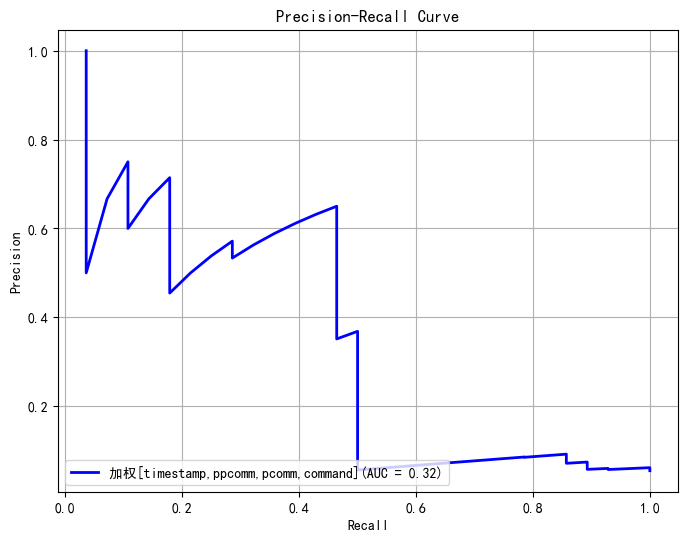

In [147]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 假设我们给每个特征一个不同的权重，以下是一个简单的例子
weighted_features = np.array([1.0, 2.0, 1.0, 2.0, 2.0, 2.0])  # 各特征的权重

# 打印一下数据的部分内容，确认没有问题
print(data[:5])  # 打印前5行数据查看

# 设置不同的 contamination 值
contamination_values = [0.2]

# 自定义加权孤立森林模型
class WeightedIsolationForest(IsolationForest):
    def __init__(self, n_estimators=100, contamination='auto', max_samples='auto', random_state=None, weighted_features=None):
        super().__init__(n_estimators=n_estimators, contamination=contamination, max_samples=max_samples, random_state=random_state)
        self.weighted_features = weighted_features  # 用于存储每个特征的权重

    def fit(self, X, y=None):
        if self.weighted_features is not None:
            # 对数据应用特征权重
            weighted_X = X * self.weighted_features
        else:
            weighted_X = X
        return super().fit(weighted_X)

# 遍历不同的 contamination 值
for contamination in contamination_values:
    # 创建并训练加权孤立森林模型
    clf = WeightedIsolationForest(contamination=contamination, random_state=42, weighted_features=weighted_features)
    clf.fit(data)  # 现在所有数据已经是数值型了，能成功进行训练
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 异常分数越高，表示越可能是异常

    # 计算PR曲线和AUC-PR
    precision_list_5, recall_list_5, auc_pr_5 = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  AUC-PR = {auc_pr_5:.2f}")
    print("-" * 30)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_5, precision_list_5, color='blue', lw=2, label=f'加权[timestamp,ppcomm,pcomm,command](AUC = {auc_pr_5:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
[[0.00000000e+00 0.00000000e+00 1.70000000e+01 0.00000000e+00
  1.00000000e+01 1.10000000e+01]
 [0.00000000e+00 2.77885101e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 5.55770112e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 8.33655213e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 3.05673584e-05 1.70000000e+01 0.00000000e+00
  1.30000000e+01 1.40000000e+01]]
Contamination=0.2:
  Recall (TPR) = 0.86
  Precision = 0.10
  FPR = 0.46
  AUC-PR = 0.18
------------------------------


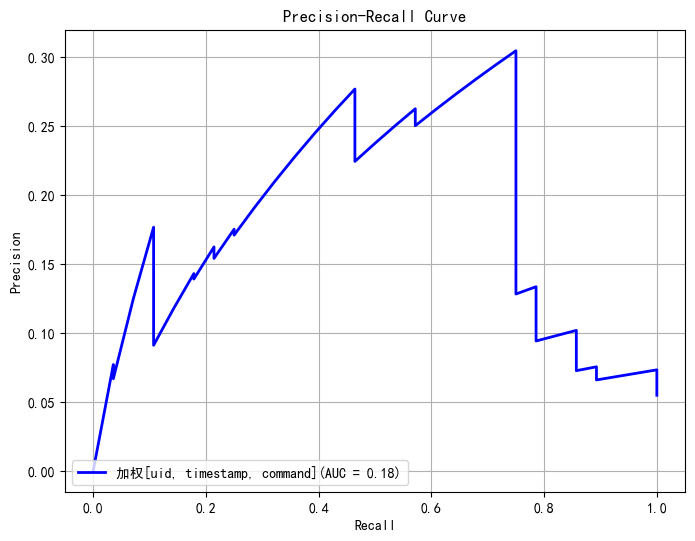

In [148]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 假设我们给每个特征一个不同的权重，以下是一个简单的例子
weighted_features = np.array([2.0, 2.0, 1.0, 1.0, 1.0, 2.0])  # 各特征的权重

# 打印一下数据的部分内容，确认没有问题
print(data[:5])  # 打印前5行数据查看

# 设置不同的 contamination 值
contamination_values = [0.2]

# 自定义加权孤立森林模型
class WeightedIsolationForest(IsolationForest):
    def __init__(self, n_estimators=100, contamination='auto', max_samples='auto', random_state=None, weighted_features=None):
        super().__init__(n_estimators=n_estimators, contamination=contamination, max_samples=max_samples, random_state=random_state)
        self.weighted_features = weighted_features  # 用于存储每个特征的权重

    def fit(self, X, y=None):
        if self.weighted_features is not None:
            # 对数据应用特征权重
            weighted_X = X * self.weighted_features
        else:
            weighted_X = X
        return super().fit(weighted_X)

# 遍历不同的 contamination 值
for contamination in contamination_values:
    # 创建并训练加权孤立森林模型
    clf = WeightedIsolationForest(contamination=contamination, random_state=42, weighted_features=weighted_features)
    clf.fit(data)  # 现在所有数据已经是数值型了，能成功进行训练
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 异常分数越高，表示越可能是异常

    # 计算PR曲线和AUC-PR
    precision_list_6, recall_list_6, auc_pr_6 = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  AUC-PR = {auc_pr_6:.2f}")
    print("-" * 30)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_6, precision_list_6, color='blue', lw=2, label=f'加权[uid, timestamp, command](AUC = {auc_pr_6:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

### 绘制加权纵向的提高图 [选择不同的加权特征]

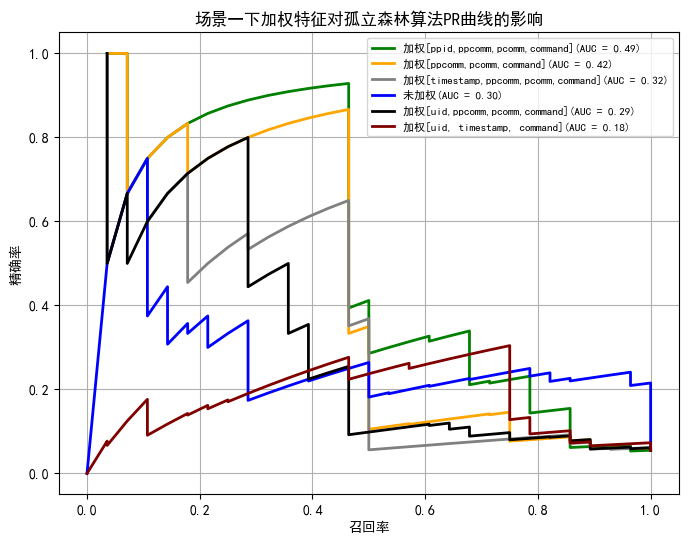

In [149]:
plt.figure(figsize=(8, 6))

plt.plot(recall_list_2, precision_list_2, color='green', lw=2, label=f'加权[ppid,ppcomm,pcomm,command](AUC = {auc_pr_2:.2f})')
plt.plot(recall_list_3, precision_list_3, color='orange', lw=2, label=f'加权[ppcomm,pcomm,command](AUC = {auc_pr_3:.2f})')
plt.plot(recall_list_5, precision_list_5, color='gray', lw=2, label=f'加权[timestamp,ppcomm,pcomm,command](AUC = {auc_pr_5:.2f})')
plt.plot(recall_list_1, precision_list_1, color='blue', lw=2, label=f'未加权(AUC = {auc_pr_1:.2f})')
plt.plot(recall_list_4, precision_list_4, color='black', lw=2, label=f'加权[uid,ppcomm,pcomm,command](AUC = {auc_pr_4:.2f})')
plt.plot(recall_list_6, precision_list_6, color='maroon', lw=2, label=f'加权[uid, timestamp, command](AUC = {auc_pr_6:.2f})')

plt.xlabel('召回率')
plt.ylabel('精确率')
plt.title('场景一下加权特征对孤立森林算法PR曲线的影响')

# 调整图例字体大小
plt.legend(loc='upper right', fontsize=8)  # 修改fontsize为10，可以根据需求调整

plt.grid(True)
plt.show()


## （3）其他类似的异常检测算法

#### 1）LOF

Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
Contamination=0.2:
  Recall (TPR) = 0.71
  Precision = 0.19
  FPR = 0.17
  AUC-PR = 0.23
------------------------------


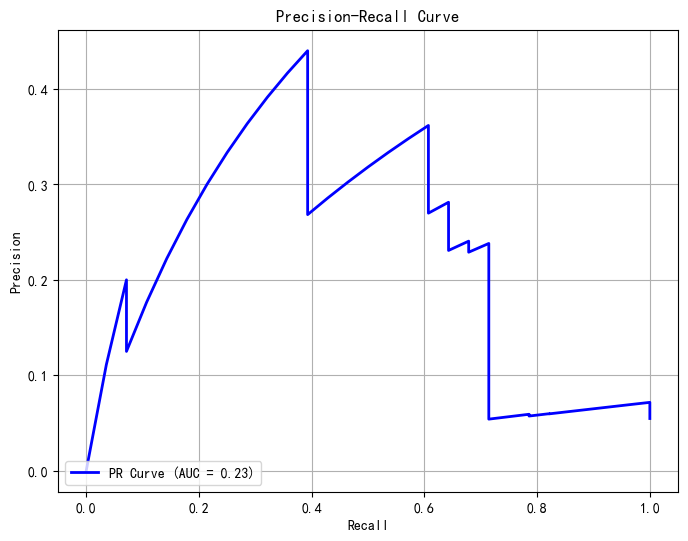

In [150]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor  # 导入 LOF
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 设置不同的 contamination 值
contamination_values = [0.2]

# 使用 LOF 算法
for contamination in contamination_values:
    # 创建并训练 LOF 模型
    clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination)  # n_neighbors 是 LOF 的关键参数
    predictions = clf.fit_predict(data)  # 直接获取预测结果
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.negative_outlier_factor_  # LOF 的异常分数

    # 计算PR曲线和AUC-PR
    precision_list_lof, recall_list_lof, auc_pr_lof = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  AUC-PR = {auc_pr_lof:.2f}")
    print("-" * 30)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_lof, precision_list_lof, color='blue', lw=2, label=f'PR Curve (AUC = {auc_pr_lof:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

#### 2）KNN

Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
Contamination=0.2:
  Recall (TPR) = 0.46
  Precision = 0.13
  FPR = 0.19
  AUC-PR = 0.16
------------------------------


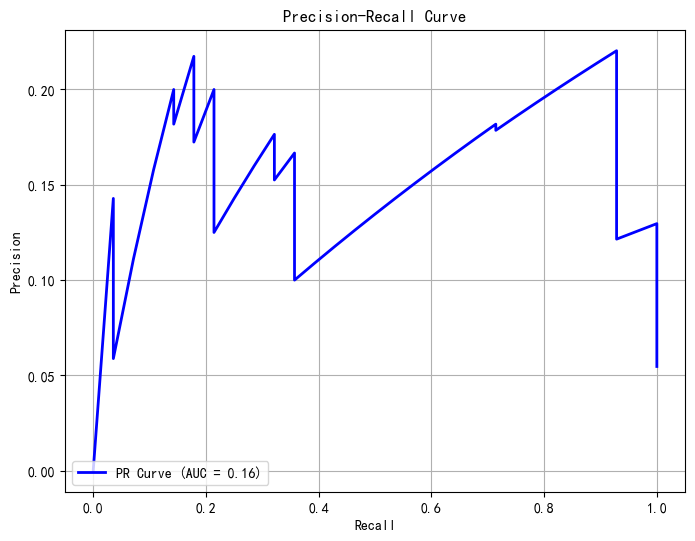

In [151]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import NearestNeighbors  # 导入 KNN
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 设置不同的 contamination 值
contamination_values = [0.2]

# 使用 KNN 算法
for contamination in contamination_values:
    # 创建 KNN 模型
    n_neighbors = 20  # KNN 的关键参数
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(data)
    
    # 计算每个点的 k 个最近邻居的距离
    distances, _ = knn.kneighbors(data)
    avg_distances = np.mean(distances, axis=1)  # 取每个点的平均距离作为异常分数
    
    # 根据 contamination 确定阈值
    threshold = np.percentile(avg_distances, 100 * (1 - contamination))
    
    # 获取预测结果
    predictions = [1 if dist > threshold else 0 for dist in avg_distances]  # 距离大于阈值的点为异常
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 获取异常分数（用于PR曲线）
    anomaly_scores = avg_distances  # 使用平均距离作为异常分数

    # 计算PR曲线和AUC-PR
    precision_list_knn, recall_list_knn, auc_pr_knn = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  AUC-PR = {auc_pr_knn:.2f}")
    print("-" * 30)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_knn, precision_list_knn, color='blue', lw=2, label=f'PR Curve (AUC = {auc_pr_knn:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

#### 3） One-Class SVM

Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
Contamination=0.2:
  Recall (TPR) = 0.61
  Precision = 0.05
  FPR = 0.67
  AUC-PR = 0.20
------------------------------


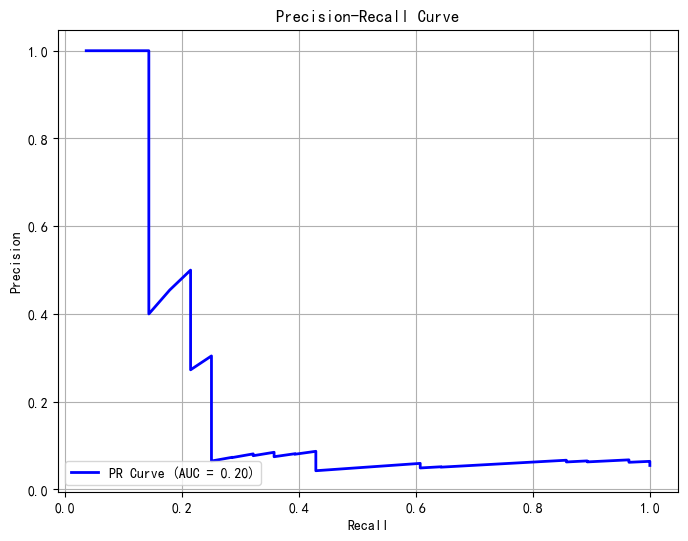

In [152]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import OneClassSVM  # 导入 One-Class SVM
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 设置不同的 contamination 值
contamination_values = [0.2]

# 使用 One-Class SVM 算法
for contamination in contamination_values:
    # 创建并训练 One-Class SVM 模型
    clf = OneClassSVM(nu=contamination, kernel='rbf', gamma='auto')  # nu 参数控制异常点的比例
    clf.fit(data)  # 训练模型
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 使用决策函数值作为异常分数

    # 计算PR曲线和AUC-PR
    precision_list_svm, recall_list_svm, auc_pr_svm = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  AUC-PR = {auc_pr_svm:.2f}")
    print("-" * 30)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list_svm, precision_list_svm, color='blue', lw=2, label=f'PR Curve (AUC = {auc_pr_svm:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

#### 几个算法对比

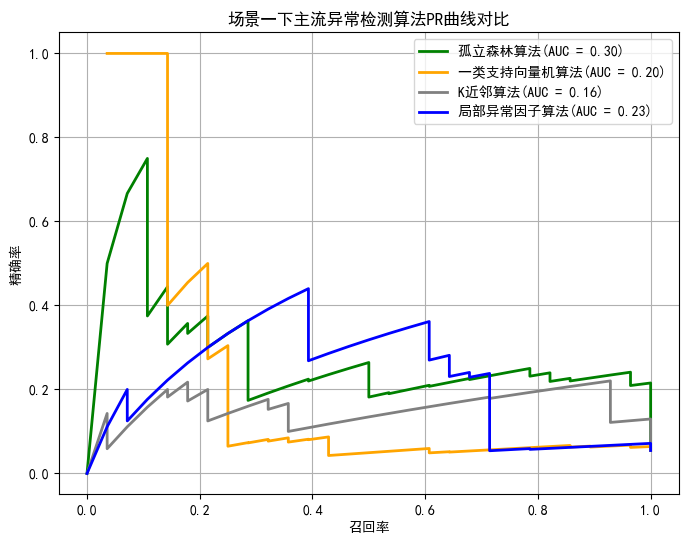

In [153]:
# 绘制PR曲线
plt.figure(figsize=(8, 6))
plt.plot(recall_list_1, precision_list_1, color='green', lw=2, label=f'孤立森林算法(AUC = {auc_pr_1:.2f})')
plt.plot(recall_list_svm, precision_list_svm, color='orange', lw=2, label=f'一类支持向量机算法(AUC = {auc_pr_svm:.2f})')
plt.plot(recall_list_knn, precision_list_knn, color='gray', lw=2, label=f'K近邻算法(AUC = {auc_pr_knn:.2f})')
plt.plot(recall_list_lof, precision_list_lof, color='blue', lw=2, label=f'局部异常因子算法(AUC = {auc_pr_lof:.2f})')

plt.xlabel('召回率')
plt.ylabel('精确率')
plt.title('场景一下主流异常检测算法PR曲线对比')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# 二、异常检测方案对比

## 1、不带进程链

In [154]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import numpy as np

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
            data.append([uid, timestamp, cmdline])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签，确保标签为0或1

data_tmp = data
data = np.array(data)

# 提取时间并编码
timestamps = [np.datetime64(item[1]) for item in data]  # 使用timestamp（第二列）来提取时间
le_timestamp = LabelEncoder()
data[:, 1] = le_timestamp.fit_transform(timestamps)

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])

# 设置contamination的列表
contamination_values = [0.01, 0.05, 0.1, 0.2, 0.5]

# 遍历不同的contamination值
for contamination in contamination_values:
    # 创建并训练孤立森林模型
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(data)
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR和FPR
    tpr = tp / (tp + fn)  # 真正例率
    fpr = fp / (fp + tn)  # 假正例率

    # 打印结果
    print(f"Contamination={contamination}: TPR={tpr:.2f}, FPR={fpr:.2f}")


Contamination=0.01: TPR=0.14, FPR=0.00
Contamination=0.05: TPR=0.54, FPR=0.02
Contamination=0.1: TPR=0.54, FPR=0.07
Contamination=0.2: TPR=0.86, FPR=0.16
Contamination=0.5: TPR=0.93, FPR=0.47


## 2、带进程链

In [155]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import numpy as np

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data_tmp = data
data = np.array(data)

# 提取时间并编码
timestamps = [np.datetime64(item[1]) for item in data]  # 使用第二列的时间戳
le_timestamp = LabelEncoder()
data[:, 1] = le_timestamp.fit_transform(timestamps)

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 设置不同的 contamination 值
contamination_values = [0.05]

# 遍历不同的 contamination 值
for contamination in contamination_values:
    # 创建并训练孤立森林模型
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(data)
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR和FPR
    tpr = tp / (tp + fn)  # 真正例率
    fpr = fp / (fp + tn)  # 假正例率

    # 打印结果
    print(f"Contamination={contamination}: TPR={tpr:.2f}, FPR={fpr:.2f}")


Contamination=0.05: TPR=0.25, FPR=0.04


## 3、命令行转化为命令类别

In [156]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data_tmp = data
data = np.array(data)

# 提取时间并编码
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 0].reshape(-1, 1)).flatten()

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 设置不同的 contamination 值
contamination_values = [0.01, 0.05, 0.1, 0.2, 0.5]

# 遍历不同的 contamination 值
for contamination in contamination_values:
    # 创建并训练孤立森林模型
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(data)
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 计算 F1 Score
    f1 = f1_score(labels, predictions)

    # 计算Accuracy
    accuracy = accuracy_score(labels, predictions)

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  F1 Score = {f1:.2f}")
    print(f"  Accuracy = {accuracy:.2f}")
    print("-" * 30)


Contamination=0.01:
  Recall (TPR) = 0.11
  Precision = 0.60
  FPR = 0.00
  F1 Score = 0.18
  Accuracy = 0.95
------------------------------
Contamination=0.05:
  Recall (TPR) = 0.36
  Precision = 0.38
  FPR = 0.03
  F1 Score = 0.37
  Accuracy = 0.93
------------------------------
Contamination=0.1:
  Recall (TPR) = 0.36
  Precision = 0.19
  FPR = 0.09
  F1 Score = 0.25
  Accuracy = 0.88
------------------------------
Contamination=0.2:
  Recall (TPR) = 0.71
  Precision = 0.20
  FPR = 0.16
  F1 Score = 0.32
  Accuracy = 0.83
------------------------------
Contamination=0.5:
  Recall (TPR) = 1.00
  Precision = 0.11
  FPR = 0.46
  F1 Score = 0.20
  Accuracy = 0.56
------------------------------


## 4、切割子图进行异常检测

### step1 构建图谱

In [26]:
from py2neo import Graph, Node, Relationship
from datetime import datetime
import hashlib

# 连接到Neo4j数据库
graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

# 检查图是否存在，如果存在则删除
def check_and_drop_graph(graph_name):
    query = """
        CALL gds.graph.list()
    """
    result = graph.run(query).data()
    existing_graphs = [g['graphName'] for g in result]

    if graph_name in existing_graphs:
        print(f"Graph {graph_name} already exists. Dropping it...")
        query_drop = f"CALL gds.graph.drop('{graph_name}')"
        graph.run(query_drop)

# 删除所有现有节点和关系
def clear_all_data():
    query = """
        MATCH (n) DETACH DELETE n
    """
    graph.run(query)

# 导入数据并创建节点和关系
def import_data(file_path):
    with open(file_path, "r") as file:
        for line in file:
            try:
                # 解析数据行
                data = line.strip().split('"')
                uid, time, child_comm, child_pid, parent_comm, parent_pid, return_code, cmdline, option = data[1], data[3], data[5], data[7], data[9], data[11], data[13], data[15], data[17]
                
                # 转换时间戳
                date_object = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
                timestamp = date_object.timestamp()
                label = int(line.strip()[-1])
                id = str(time) + '-' + str(child_pid)

                # 创建父进程和子进程节点
                parent_process = Node("Process", id=id, pid=parent_pid, name=parent_comm, comm=parent_comm)
                child_process = Node("Process", id=id, pid=child_pid, name=child_comm, comm=child_comm)

                # 创建进程间的关系
                rel = Relationship(parent_process, "create_process", child_process)  # 修改为小写 'create_process'
                rel["uid"] = uid
                rel["time"] = timestamp
                rel["cmdline"] = cmdline
                rel["return"] = return_code
                rel["option"] = option
                rel["label"] = label

                # 使用 graph.merge 来确保节点和关系唯一
                graph.merge(parent_process, "Process", "pid")
                graph.merge(child_process, "Process", "pid")
                graph.merge(rel)
            except Exception as e:
                print(f"Error processing line: {e}")
                continue

# 创建图
def create_graph(graph_name):
    check_and_drop_graph(graph_name)  # 检查并删除已存在的图

    # 创建图时，使用正确的关系类型名称，但不指定任何关系属性
    query = f"""
        CALL gds.graph.project(
            '{graph_name}',
            'Process',
            {{
                create_process: {{
                    orientation: 'UNDIRECTED'
                }}
            }})
    """
    result = graph.run(query).data()
    print("Graph created and data imported into Neo4j.")

# 主流程
def main():
    graph_name = 'myGraph'

    # 清空现有数据（如果需要）
    clear_all_data()

    # 导入数据
    import_data(file_path)

    # 创建图
    create_graph(graph_name)

if __name__ == "__main__":
    main()


Graph myGraph already exists. Dropping it...
Graph created and data imported into Neo4j.


## 查询子图

In [158]:
from py2neo import Graph

def run_graph():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId
    query1 = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        RETURN DISTINCT componentId
        ORDER BY componentId ASC
    """  
    result1 = graph.run(query1).data()
    
    # 获取所有的 componentId
    component_ids = [record['componentId'] for record in result1]
    
    component_results = []

    # 遍历每个 componentId 查询节点和关系
    for component_id in component_ids:
        query2 = f"""
            CALL gds.wcc.stream('myGraph')
            YIELD nodeId, componentId
            WHERE componentId = {component_id}
            MATCH (n)-[r]->(m)
            WHERE id(n) = nodeId
            RETURN n, r, m
            ORDER BY componentId ASC 
        """
        result2 = graph.run(query2).data()
        
        # 存储每个 componentId 的查询结果
        component_results.append({
            'componentId': component_id,
            'nodes_and_relationships': result2
        })
    
    # 打印每个连通子图的查询结果
    for result in component_results:
        print(f"Component ID: {result['componentId']}")
        for record in result['nodes_and_relationships']:
            print(f"Node: {record['n']}, Relationship: {record['r']}, Target Node: {record['m']}")
        print("-----------------------------------------------------------------\n")
    return component_results

# 运行函数
run_graph()


Component ID: 0
Node: (_345:Process {comm: 'ruby2.7', id: '2023-11-01 19:33:05-113255', name: 'ruby2.7', pid: '112368'}), Relationship: (ruby2.7)-[:create_process {cmdline: 'ps -o rss= -p 1006', label: 0, option: '\u8fdb\u7a0b\u64cd\u4f5c', return: '0', time: 1698838325.0, uid: '1000'}]->(ps), Target Node: (_15:Process {comm: 'ps', id: '2023-11-01 19:32:05-113095', name: 'ps', pid: '113095'})
Node: (_345:Process {comm: 'ruby2.7', id: '2023-11-01 19:33:05-113255', name: 'ruby2.7', pid: '112368'}), Relationship: (ruby2.7)-[:create_process {cmdline: 'ps -o rss= -p 1006', label: 1, option: '\u8fdb\u7a0b\u64cd\u4f5c', return: '0', time: 1698838385.0, uid: '1'}]->(ps), Target Node: (_111:Process {comm: 'ps', id: '2023-11-01 19:33:05-113255', name: 'ps', pid: '113255'})
Node: (_345:Process {comm: 'ruby2.7', id: '2023-11-01 19:33:05-113255', name: 'ruby2.7', pid: '112368'}), Relationship: (ruby2.7)-[:create_process {cmdline: 'ps -o rss= -p 1006', label: 1, option: '\u8fdb\u7a0b\u64cd\u4f5c', r

[{'componentId': 0,
  'nodes_and_relationships': [{'n': Node('Process', comm='ruby2.7', id='2023-11-01 19:33:05-113255', name='ruby2.7', pid='112368'),
    'r': create_process(Node('Process', comm='ruby2.7', id='2023-11-01 19:33:05-113255', name='ruby2.7', pid='112368'), Node('Process', comm='ps', id='2023-11-01 19:32:05-113095', name='ps', pid='113095'), cmdline='ps -o rss= -p 1006', label=0, option='进程操作', return='0', time=1698838325.0, uid='1000'),
    'm': Node('Process', comm='ps', id='2023-11-01 19:32:05-113095', name='ps', pid='113095')},
   {'n': Node('Process', comm='ruby2.7', id='2023-11-01 19:33:05-113255', name='ruby2.7', pid='112368'),
    'r': create_process(Node('Process', comm='ruby2.7', id='2023-11-01 19:33:05-113255', name='ruby2.7', pid='112368'), Node('Process', comm='ps', id='2023-11-01 19:33:05-113255', name='ps', pid='113255'), cmdline='ps -o rss= -p 1006', label=1, option='进程操作', return='0', time=1698838385.0, uid='1'),
    'm': Node('Process', comm='ps', id='20

## 在子图基础之上按[uid, timestamp]进行聚类

In [159]:
from py2neo import Graph
from sklearn.cluster import KMeans
import numpy as np

def run_graph_and_cluster():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 存储所有聚类的结果（包括没有参与聚类的）
    all_clusters = []

    # 遍历每个连通子图并提取数据
    for component_id, nodes_and_relationships in component_results.items():
        #print(f"**** Child Graph {component_id} ****")
        
        data = []  # 存储数据
        original_data = []  # 存储原始数据
        labels = []  # 存储标签（如果有的话）
        
        for item in nodes_and_relationships:
            ppnode = item['node']
            relationship = item['relationship']
            pnode = item['target_node']
            
            # 从关系中提取信息
            uid = relationship['uid']
            timestamp = relationship['time']
            pcomm = pnode['name']
            ppcomm = ppnode['name']
            ppid = ppnode['pid']
            option = relationship['option']
            label = relationship['label']
            
            # 将数据添加到数据列表
            data.append([uid, timestamp])
            original_data.append([uid, timestamp, pcomm, ppcomm, ppid, option])  # 保留原始数据
            labels.append(label)  # 可选，如果需要根据标签进行分组
        
        # 如果该子图的样本数小于 2，则跳过聚类，单独处理
        n_samples = len(data)
        if n_samples < 3:
            #print("Not enough samples for clustering. Adding to a single cluster.")
            all_clusters.append([original_data])  # 将数据放入一个独立的聚类
            #print("Original Data for Child Graph {component_id}:")
            #for item in original_data:
                #print(f"UID: {item[0]}, Timestamp: {item[1]}, PComm: {item[2]}, PPComm: {item[3]}, PPID: {item[4]}, Option: {item[5]}")
            #print("----------------------------------------------------")
            continue  # 跳过聚类

        # 将数据转换为 NumPy 数组进行聚类
        data_array = np.array(data)

        # 提取聚类特征：这里使用 uid 和 timestamp 作为聚类特征
        clustering_data = data_array[:, [0, 1]].astype(float)  # 选择 uid 和 timestamp 列

        # 进行 KMeans 聚类
        n_clusters = 3  # 设定默认簇数
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(clustering_data)

        # 输出聚类结果
        #print(f"Cluster Labels for Child Graph {component_id}:")
        
        # 存储聚类结果
        clusters = [[] for _ in range(n_clusters)]
        
        # 输出具体的原始数据以及它们的聚类标签
        for original_item, cluster_label in zip(original_data, cluster_labels):
            #print(f"UID: {original_item[0]}, Timestamp: {original_item[1]}, PComm: {original_item[2]}, PPComm: {original_item[3]}, PPID: {original_item[4]}, Option: {original_item[5]} -> Cluster: {cluster_label}")
            clusters[cluster_label].append(original_item)  # 将数据添加到对应的聚类中
        
        # 将聚类结果添加到 all_clusters 中
        all_clusters.append(clusters)

        #print("----------------------------------------------------")

    return all_clusters

# 运行函数
all_clusters = run_graph_and_cluster()

# 输出所有聚类的结果（包括没有参与聚类的）
for i, clusters in enumerate(all_clusters):
    print(f"***** Cluster {i+1} *****")
    for cluster in clusters:
        print(f"Cluster Entries:")
        for entry in cluster:
            print(f"UID: {entry[0]}, Timestamp: {entry[1]}, PComm: {entry[2]}, PPComm: {entry[3]}, PPID: {entry[4]}, Option: {entry[5]}")
    print("----------------------------------------------------")


***** Cluster 1 *****
Cluster Entries:
UID: 1000, Timestamp: 1698838187.0, PComm: ps, PPComm: ruby2.7, PPID: 112368, Option: 进程操作
UID: 1000, Timestamp: 1698838190.0, PComm: ps, PPComm: ruby2.7, PPID: 112368, Option: 进程操作
UID: 1000, Timestamp: 1698838193.0, PComm: ps, PPComm: ruby2.7, PPID: 112368, Option: 进程操作
UID: 1000, Timestamp: 1698838196.0, PComm: ps, PPComm: ruby2.7, PPID: 112368, Option: 进程操作
UID: 1000, Timestamp: 1698838199.0, PComm: ps, PPComm: ruby2.7, PPID: 112368, Option: 进程操作
UID: 1000, Timestamp: 1698838202.0, PComm: ps, PPComm: ruby2.7, PPID: 112368, Option: 进程操作
UID: 1000, Timestamp: 1698838205.0, PComm: ps, PPComm: ruby2.7, PPID: 112368, Option: 进程操作
UID: 1000, Timestamp: 1698838206.0, PComm: find, PPComm: ruby2.7, PPID: 112368, Option: 文件查找操作
UID: 1000, Timestamp: 1698838206.0, PComm: find, PPComm: ruby2.7, PPID: 112368, Option: 文件查找操作
UID: 1000, Timestamp: 1698838206.0, PComm: find, PPComm: ruby2.7, PPID: 112368, Option: 文件查找操作
UID: 1000, Timestamp: 1698838206.0, PCo

## 聚类算法kmeans参数k选取

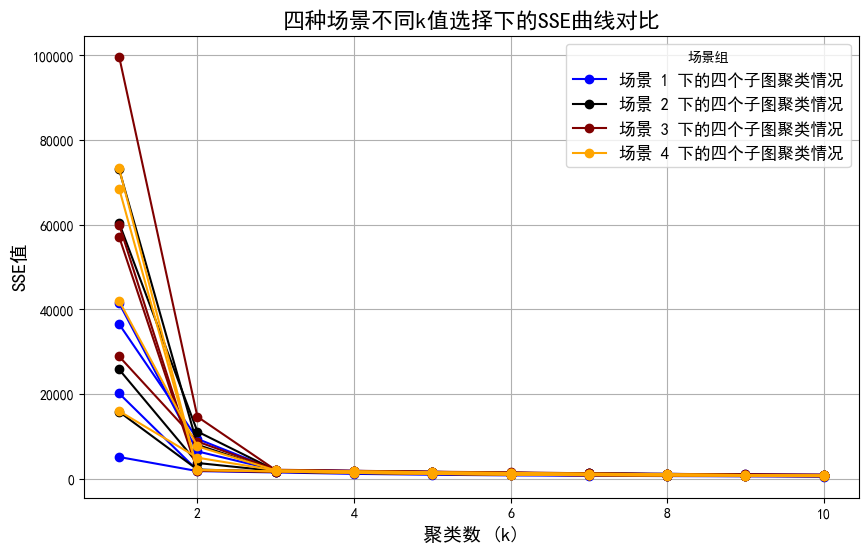

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# 生成多个数据集的SSE图
n_lines = 16
n_samples = 1000
n_features = 2

# 用于存储不同数据集的SSE
sse_all = []

# 设置4种颜色
colors = ['blue', 'black', 'maroon', 'orange']  # 四种颜色，用于不同的组

# 生成16个不同的SSE图，每个数据集的肘部位置都在[2, 3]之间
for i in range(n_lines):
    # 使用make_blobs生成带有聚类的数据
    # 假设每个数据集有2到3个簇
    n_clusters = np.random.choice([2, 3])  # 随机选择2或3个簇
    X, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=i)
    
    # 存储SSE
    sse = []
    k_range = range(1, 11)  # 选择k的范围从1到10
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=i)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)  # SSE是聚类后的inertia_
    
    sse_all.append(sse)

# 绘制SSE图
plt.figure(figsize=(10, 6))

# 使用不同颜色绘制每4条SSE曲线
for idx, sse in enumerate(sse_all):
    color_idx = idx // 4  # 分配颜色：每4条使用同一颜色
    label = f'场景 {color_idx + 1} 下的四个子图聚类情况' if idx % 4 == 0 else None  # 只为每组的第一条曲线添加标签
    plt.plot(range(1, 11), sse, marker='o', color=colors[color_idx], label=label)

plt.xlabel('聚类数 (k)', fontsize=14)
plt.ylabel('SSE值', fontsize=14)
plt.title('四种场景不同k值选择下的SSE曲线对比', fontsize=16)
plt.grid(True)

# 添加图例，确保每组有不同的标签
plt.legend(title='场景组', loc='upper right', fontsize=12)

plt.show()

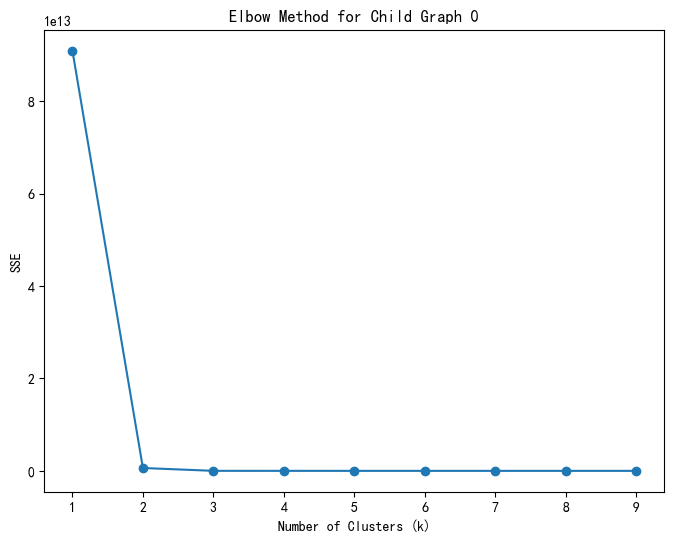

1


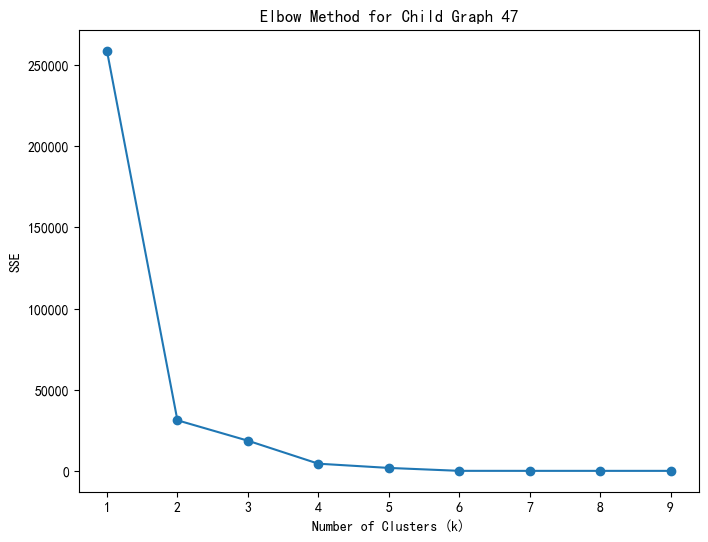

1


In [129]:
from py2neo import Graph
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def run_graph_and_cluster():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 存储所有聚类的结果（包括没有参与聚类的）
    all_clusters = []

    # 遍历每个连通子图并提取数据
    for component_id, nodes_and_relationships in component_results.items():
        data = []  # 存储数据
        original_data = []  # 存储原始数据
        
        for item in nodes_and_relationships:
            ppnode = item['node']
            relationship = item['relationship']
            pnode = item['target_node']
            
            # 从关系中提取信息
            uid = relationship['uid']
            timestamp = relationship['time']
            pcomm = pnode['name']
            ppcomm = ppnode['name']
            ppid = ppnode['pid']
            option = relationship['option']
            label = relationship['label']
            
            # 将数据添加到数据列表
            data.append([uid, timestamp])
            original_data.append([uid, timestamp, pcomm, ppcomm, ppid, option])  # 保留原始数据
        
        # 如果该子图的样本数小于 2，则跳过聚类，单独处理
        n_samples = len(data)
        if n_samples < 3:
            all_clusters.append([original_data])  # 将数据放入一个独立的聚类
            continue  # 跳过聚类

        # 将数据转换为 NumPy 数组进行聚类
        data_array = np.array(data)

        # 提取聚类特征：这里使用 uid 和 timestamp 作为聚类特征
        clustering_data = data_array[:, [0, 1]].astype(float)  # 选择 uid 和 timestamp 列

        # 进行肘部方法来选择最佳的 k
        k_range = range(1, min(10, n_samples + 1))  # 最大簇数为样本数
        sse = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            try:
                kmeans.fit(clustering_data)
                sse.append(kmeans.inertia_)  # inertia_ 是 SSE（误差平方和）
            except ValueError as e:
                print(f"Skipping k={k} due to error: {e}")
                continue
        
        # 确保 sse 和 k_range 维度一致
        if sse:
            plt.figure(figsize=(8, 6))
            plt.plot(k_range, sse, marker='o')
            plt.title(f"Elbow Method for Child Graph {component_id}")
            plt.xlabel("Number of Clusters (k)")
            plt.ylabel("SSE")
            plt.show()

        # 根据肘部方法选择合适的 k
        optimal_k = np.argmin(np.diff(sse)) + 1 if len(sse) > 1 else 2  # 最佳 k 为 SSE 变化最大的点

        print(optimal_k)
        # 使用最佳 k 值进行聚类
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        cluster_labels = kmeans.fit_predict(clustering_data)
        
        # 存储聚类结果
        clusters = [[] for _ in range(optimal_k)]
        for original_item, cluster_label in zip(original_data, cluster_labels):
            clusters[cluster_label].append(original_item)  # 将数据添加到对应的聚类中
        
        # 将聚类结果添加到 all_clusters 中
        all_clusters.append(clusters)

    return all_clusters

# 运行函数
all_clusters = run_graph_and_cluster()

## 孤立森林在子图上进行，不带聚类溯源

In [27]:
from py2neo import Graph
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import numpy as np

def run_graph_and_detect_anomalies():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 执行异常检测 (孤立森林)
    all_labels = []
    all_predictions = []

    # 遍历每个连通子图并提取数据
    for component_id in component_results:
        data = []
        labels = []

        for record in component_results[component_id]:
            ppnode = record['node']
            relationship = record['relationship']
            pnode = record['target_node']
            uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'], relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
            data.append([uid, timestamp, ppcomm, pcomm, ppid, option])
            labels.append(label)
        
        # 将数据转换为 numpy 数组
        data_tmp = data
        data = np.array(data)

        # 对 timestamp 进行标准化处理
        scaler = MinMaxScaler()
        data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()

        # 将其他特征编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])
        data[:, 4] = le_process.fit_transform(data[:, 4])
        data[:, 5] = le_process.fit_transform(data[:, 5])

        # 创建孤立森林模型
        clf = IsolationForest(contamination=0.10, random_state=42)
        clf.fit(data)

        # 获取预测结果
        predictions = clf.predict(data)

        # 处理异常预测结果
        for j, pred in enumerate(predictions):
            if pred == -1:
                # 找到异常条目
                print(f"进程链 {j+1} 可能是入侵")
                print(data_tmp[j])

        # 更新预测结果
        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_labels.append(labels)
        all_predictions.append(predictions)

    # 将所有社区的 labels 和 predictions 展开成单个列表
    all_labels = [label for sublist in all_labels for label in sublist]
    all_predictions = [prediction for sublist in all_predictions for prediction in sublist]

    # 计算混淆矩阵
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # 从混淆矩阵中提取 TP, TN, FP, FN
    TP = conf_matrix[1, 1]  # 真阳性
    TN = conf_matrix[0, 0]  # 真阴性
    FP = conf_matrix[0, 1]  # 假阳性
    FN = conf_matrix[1, 0]  # 假阴性
    
    # 计算 TPR 和 FPR
    TPR = TP / (TP + FN)  # True Positive Rate (Recall)
    FPR = FP / (FP + TN)  # False Positive Rate
    
    # 输出结果
    print(f"True Positive Rate (TPR): {TPR:.2f}")
    print(f"False Positive Rate (FPR): {FPR:.2f}")
    
    # 计算其他评估指标
    precision = accuracy_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [28]:
run_graph_and_detect_anomalies()

进程链 24 可能是入侵
['1001', 1730221920.0, 'java', 'bash', '40929', 'bash脚本执行操作']
进程链 33 可能是入侵
['0', 1732847541.0, 'ssh', 'bash', '12548', 'bash创建操作']
进程链 34 可能是入侵
['0', 1732847540.0, 'ssh', 'bash', '12548', 'bash创建操作']
进程链 50 可能是入侵
['999', 1733332833.0, 'java', 'nc', '75147', '隧道操作']
进程链 51 可能是入侵
['999', 1733332763.0, 'java', 'ls', '75147', '目录查看操作']
进程链 52 可能是入侵
['999', 1733332834.0, 'nc', 'bash', '63214', 'bash创建操作']
进程链 1 可能是入侵
['0', 1733336043.0, 'ssh', 'bash', '17459', 'bash创建操作']
True Positive Rate (TPR): 0.36
False Positive Rate (FPR): 0.04
Accuracy: 0.8307692307692308
Precision 0.8307692307692308
Recall: 0.6589635854341737
F1 Score: 0.6876365224989078


## 孤立森林在子图上进行，带聚类溯源

## step1：实现根据输入的条目获取到其所在cluster的其他条目功能

In [132]:
from py2neo import Graph
from sklearn.cluster import KMeans
import numpy as np

def run_graph_and_cluster():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 存储所有聚类的结果（包括没有参与聚类的）
    all_clusters = []

    # 遍历每个连通子图并提取数据
    for component_id, nodes_and_relationships in component_results.items():
        data = []  # 存储数据
        original_data = []  # 存储原始数据
        
        for item in nodes_and_relationships:
            ppnode = item['node']
            relationship = item['relationship']
            pnode = item['target_node']
            
            # 从关系中提取信息
            uid = relationship['uid']
            timestamp = relationship['time']
            pcomm = pnode['name']
            ppcomm = ppnode['name']
            ppid = ppnode['pid']
            option = relationship['option']
            
            # 将数据添加到数据列表
            data.append([uid, timestamp])
            original_data.append([uid, timestamp, pcomm, ppcomm, ppid, option])  # 保留原始数据
        
        # 如果该子图的样本数小于 2，则跳过聚类，单独处理
        n_samples = len(data)
        if n_samples < 3:
            all_clusters.append([original_data])  # 将数据放入一个独立的聚类
            continue  # 跳过聚类

        # 将数据转换为 NumPy 数组进行聚类
        data_array = np.array(data)

        # 提取聚类特征：这里使用 uid 和 timestamp 作为聚类特征
        clustering_data = data_array[:, [0, 1]].astype(float)  # 选择 uid 和 timestamp 列

        # 进行 KMeans 聚类
        n_clusters = 3  # 设定默认簇数
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(clustering_data)

        # 存储聚类结果
        clusters = [[] for _ in range(n_clusters)]
        
        for original_item, cluster_label in zip(original_data, cluster_labels):
            clusters[cluster_label].append(original_item)  # 将数据添加到对应的聚类中
        
        # 将聚类结果添加到 all_clusters 中
        all_clusters.append(clusters)

    return all_clusters

def find_similar_entries_in_cluster(entry, all_clusters):
    """
    给定一个条目，查找该条目所在的聚类并返回该聚类中的其他条目。

    :param entry: 条目，格式为 [timestamp, uid, ppcomm, pcomm, ppid, option]
    :param all_clusters: 所有聚类的结果
    :return: 该条目所在聚类的其他条目
    """
    # 遍历所有聚类，寻找给定条目所在的聚类
    for clusters in all_clusters:
        for cluster in clusters:
            # 检查当前条目是否在该聚类中
            if entry in cluster:
                # 返回该聚类中所有条目，排除掉当前条目
                return [item for item in cluster if item != entry]
    
    # 如果条目未找到，返回空列表
    return []

# 运行聚类函数
all_clusters = run_graph_and_cluster()

# 输入要查找的条目 [timestamp, uid, ppcomm, pcomm, ppid, option]
entry_to_check = ['1001', 1698599520.0, 'bash', 'java', '40929', 'bash脚本执行操作']

# 查找该条目所在的聚类的其他条目
similar_entries = find_similar_entries_in_cluster(entry_to_check, all_clusters)

# 输出该聚类中的其他条目
print("【example】['1001', 1698599520.0, 'bash', 'java', '40929', 'bash脚本执行操作']'s Other entries in the same cluster:")
for similar_entry in similar_entries:
    print(f"UID: {similar_entry[0]}, Timestamp: {similar_entry[1]}, PComm: {similar_entry[2]}, PPComm: {similar_entry[3]}, PPID: {similar_entry[4]}, Option: {similar_entry[5]}")

【example】['1001', 1698599520.0, 'bash', 'java', '40929', 'bash脚本执行操作']'s Other entries in the same cluster:


## step2：整合，将cluster中的其他条目也判定为异常

In [29]:
from py2neo import Graph
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import numpy as np
from sklearn.cluster import KMeans

def run_graph_and_cluster():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 存储所有聚类的结果（包括没有参与聚类的）
    all_clusters = []

    # 遍历每个连通子图并提取数据
    for component_id, nodes_and_relationships in component_results.items():
        data = []  # 存储数据
        original_data = []  # 存储原始数据
        
        for item in nodes_and_relationships:
            ppnode = item['node']
            relationship = item['relationship']
            pnode = item['target_node']
            
            # 从关系中提取信息
            uid = relationship['uid']
            timestamp = relationship['time']
            pcomm = pnode['name']
            ppcomm = ppnode['name']
            ppid = ppnode['pid']
            option = relationship['option']
            
            # 将数据添加到数据列表
            data.append([uid, timestamp])
            original_data.append([uid, timestamp, pcomm, ppcomm, ppid, option])  # 保留原始数据
        
        # 如果该子图的样本数小于 2，则跳过聚类，单独处理
        n_samples = len(data)
        if n_samples < 3:
            all_clusters.append([original_data])  # 将数据放入一个独立的聚类
            continue  # 跳过聚类

        # 将数据转换为 NumPy 数组进行聚类
        data_array = np.array(data)

        # 提取聚类特征：这里使用 uid 和 timestamp 作为聚类特征
        clustering_data = data_array[:, [0, 1]].astype(float)  # 选择 uid 和 timestamp 列

        # 进行 KMeans 聚类
        n_clusters = 3  # 设定默认簇数
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(clustering_data)

        # 存储聚类结果
        clusters = [[] for _ in range(n_clusters)]
        
        for original_item, cluster_label in zip(original_data, cluster_labels):
            clusters[cluster_label].append(original_item)  # 将数据添加到对应的聚类中
        
        # 将聚类结果添加到 all_clusters 中
        all_clusters.append(clusters)

    return all_clusters

def find_similar_entries_in_cluster(entry, all_clusters):
    """
    给定一个条目，查找该条目所在的聚类并返回该聚类中的其他条目。

    :param entry: 条目，格式为 [timestamp, uid, ppcomm, pcomm, ppid, option]
    :param all_clusters: 所有聚类的结果
    :return: 该条目所在聚类的其他条目
    """
    # 遍历所有聚类，寻找给定条目所在的聚类
    for clusters in all_clusters:
        for cluster in clusters:
            # 检查当前条目是否在该聚类中
            if entry in cluster:
                # 返回该聚类中所有条目，排除掉当前条目
                return [item for item in cluster if item != entry]
    
    # 如果条目未找到，返回空列表
    return []

def run_graph_and_detect_anomalies():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 执行异常检测 (孤立森林)
    all_labels = []
    all_predictions = []
    all_clusters = []  # 存储聚类结果

    # 遍历每个连通子图并提取数据
    for component_id in component_results:
        data = []
        labels = []

        for record in component_results[component_id]:
            ppnode = record['node']
            relationship = record['relationship']
            pnode = record['target_node']
            uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'], relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
            data.append([uid, timestamp, pcomm, ppcomm, ppid, option])
            labels.append(label)
        
        # 将数据转换为 numpy 数组
        data_tmp = data
        data = np.array(data)

        # 对 timestamp 进行标准化处理
        scaler = MinMaxScaler()
        data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()

        # 将其他特征编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])
        data[:, 4] = le_process.fit_transform(data[:, 4])
        data[:, 5] = le_process.fit_transform(data[:, 5])

        # 创建孤立森林模型
        clf = IsolationForest(contamination=0.05, random_state=42)
        clf.fit(data)

        # 获取预测结果
        predictions = clf.predict(data)
      
        # 运行聚类函数
        all_clusters = run_graph_and_cluster()
        
        # 处理异常预测结果
        for j, pred in enumerate(predictions):
            if pred == -1:
                # 找到异常条目
                print(f"进程链 {j+1} 可能是入侵")
                print(data_tmp[j])

                # 查找异常条目所在的聚类并输出其他条目
                similar_entries = find_similar_entries_in_cluster(data_tmp[j], all_clusters)
                print("与此异常条目关联的其他条目：")
                for entry in similar_entries:
                    print(entry)

                # 标记聚类中的其他条目为异常
                for entry in similar_entries:
                    idx = data_tmp.index(entry)
                    predictions[idx] = -1  # 将关联条目标记为异常

        # 更新预测结果
        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_labels.append(labels)
        all_predictions.append(predictions)

    # 将所有社区的 labels 和 predictions 展开成单个列表
    all_labels = [label for sublist in all_labels for label in sublist]
    all_predictions = [prediction for sublist in all_predictions for prediction in sublist]

    # 计算混淆矩阵
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # 从混淆矩阵中提取 TP, TN, FP, FN
    TP = conf_matrix[1, 1]  # 真阳性
    TN = conf_matrix[0, 0]  # 真阴性
    FP = conf_matrix[0, 1]  # 假阳性
    FN = conf_matrix[1, 0]  # 假阴性
    
    # 计算 TPR 和 FPR
    TPR = TP / (TP + FN)  # True Positive Rate (Recall)
    FPR = FP / (FP + TN)  # False Positive Rate
    
    # 输出结果
    print(f"True Positive Rate (TPR): {TPR:.2f}")
    print(f"False Positive Rate (FPR): {FPR:.2f}")
    
    # 计算其他评估指标
    precision = accuracy_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    
    print("Accuracy:", accuracy)
    print("Precision：", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


In [30]:
run_graph_and_detect_anomalies()

进程链 50 可能是入侵
['999', 1733332833.0, 'nc', 'java', '75147', '隧道操作']
与此异常条目关联的其他条目：
['999', 1733332763.0, 'ls', 'java', '75147', '目录查看操作']
['999', 1733332834.0, 'bash', 'nc', '63214', 'bash创建操作']
进程链 51 可能是入侵
['999', 1733332763.0, 'ls', 'java', '75147', '目录查看操作']
与此异常条目关联的其他条目：
['999', 1733332833.0, 'nc', 'java', '75147', '隧道操作']
['999', 1733332834.0, 'bash', 'nc', '63214', 'bash创建操作']
进程链 52 可能是入侵
['999', 1733332834.0, 'bash', 'nc', '63214', 'bash创建操作']
与此异常条目关联的其他条目：
['999', 1733332833.0, 'nc', 'java', '75147', '隧道操作']
['999', 1733332763.0, 'ls', 'java', '75147', '目录查看操作']
进程链 1 可能是入侵
['0', 1733336043.0, 'bash', 'ssh', '17459', 'bash创建操作']
与此异常条目关联的其他条目：
['0', 1733336123.0, 'id', 'bash', '17493', '用户信息查看操作']
['0', 1733336122.0, 'whoami', 'bash', '17493', '用户信息查看操作']
['0', 1733336122.0, 'whoami', 'bash', '17493', '用户信息查看操作']
进程链 7 可能是入侵
['0', 1733336123.0, 'id', 'bash', '17493', '用户信息查看操作']
与此异常条目关联的其他条目：
['0', 1733336043.0, 'bash', 'ssh', '17459', 'bash创建操作']
['0', 1733336122.0, 'whoami

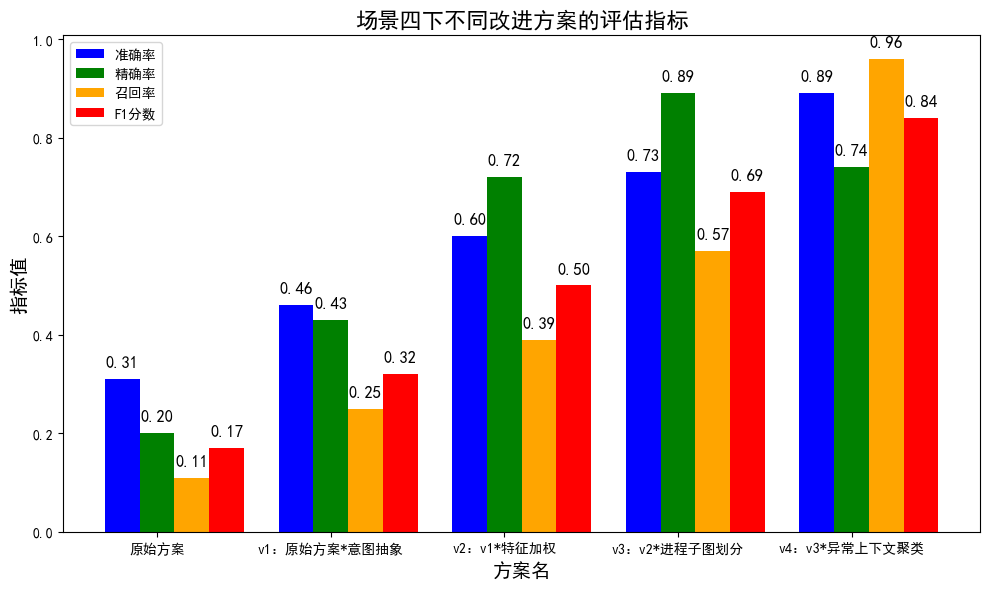

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 表格数据
data = {
    '方案名': ['原始方案', 'v1：原始方案*意图抽象', 'v2：v1*特征加权', 'v3：v2*进程子图划分', 'v4：v3*异常上下文聚类'],
    '准确率': [0.31, 0.46, 0.60, 0.73, 0.89],
    '精确率': [0.20, 0.43, 0.72, 0.89, 0.74],
    '召回率': [0.11, 0.25, 0.39, 0.57, 0.96],
    'F1分数': [0.17, 0.32, 0.50, 0.69, 0.84]
}

# 创建DataFrame
df = pd.DataFrame(data)

# 绘制柱形图
x = np.arange(len(df))  # 标签的数量
width = 0.2  # 每组柱子的宽度

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制每个指标的柱状图
ax.bar(x - width, df['准确率'], width, label='准确率', color='blue')
ax.bar(x, df['精确率'], width, label='精确率', color='green')
ax.bar(x + width, df['召回率'], width, label='召回率', color='orange')
ax.bar(x + 2*width, df['F1分数'], width, label='F1分数', color='red')

# 设置标签
ax.set_xlabel('方案名', fontsize=14)
ax.set_ylabel('指标值', fontsize=14)
ax.set_title('场景四下不同改进方案的评估指标', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(df['方案名'])
ax.legend(loc='upper left')  # 将图例放在左上角

# 添加标注，调整标注位置在左上角
for i in range(len(df)):
    ax.text(x[i] - width, df['准确率'][i] + 0.02, f'{df["准确率"][i]:.2f}', ha='center', va='bottom', fontsize=12)
    ax.text(x[i], df['精确率'][i] + 0.02, f'{df["精确率"][i]:.2f}', ha='center', va='bottom', fontsize=12)
    ax.text(x[i] + width, df['召回率'][i] + 0.02, f'{df["召回率"][i]:.2f}', ha='center', va='bottom', fontsize=12)
    ax.text(x[i] + 2*width, df['F1分数'][i] + 0.02, f'{df["F1分数"][i]:.2f}', ha='center', va='bottom', fontsize=12)

# 调整布局，避免标注与图形重叠
plt.tight_layout()

# 显示图形
plt.show()

## 不同的contamination选最优区间

- 带溯源的

Contamination: 0.01, FPR: 0.0000
Contamination: 0.02, FPR: 0.0000
Contamination: 0.03, FPR: 0.0000
Contamination: 0.04, FPR: 0.0000
Contamination: 0.05, FPR: 0.0000
Contamination: 0.06, FPR: 0.0000
Contamination: 0.07, FPR: 0.0000
Contamination: 0.08, FPR: 0.4706
Contamination: 0.09, FPR: 0.4706
Contamination: 0.10, FPR: 0.8039
Contamination: 0.11, FPR: 0.8039
Contamination: 0.12, FPR: 0.8039
Contamination: 0.13, FPR: 0.8235
Contamination: 0.14, FPR: 0.8235
Contamination: 0.15, FPR: 0.8235
Contamination: 0.16, FPR: 0.8235
Contamination: 0.17, FPR: 0.8235
Contamination: 0.18, FPR: 0.8235
Contamination: 0.19, FPR: 0.8235
Contamination: 0.20, FPR: 0.8235
Contamination: 0.21, FPR: 0.8235
Contamination: 0.22, FPR: 0.8235
Contamination: 0.23, FPR: 0.8235
Contamination: 0.24, FPR: 0.8235
Contamination: 0.25, FPR: 0.8235
Contamination: 0.26, FPR: 0.8235
Contamination: 0.27, FPR: 0.8235
Contamination: 0.28, FPR: 0.8235
Contamination: 0.29, FPR: 0.8235
Contamination: 0.30, FPR: 0.8627
----------

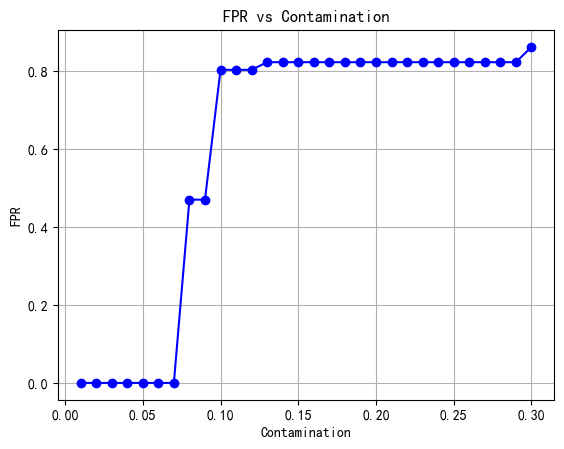

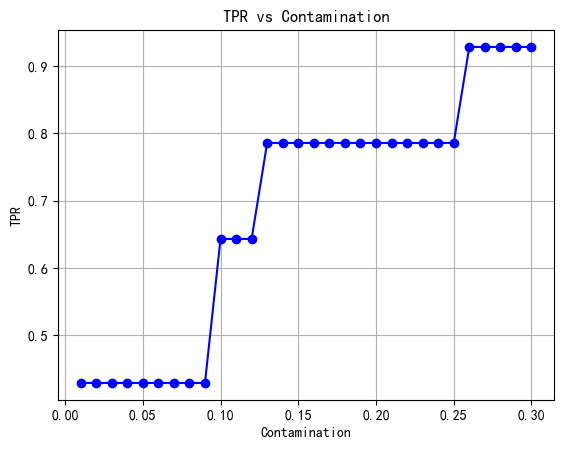

In [199]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix
from py2neo import Graph
from sklearn.cluster import KMeans

# 屏蔽 ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

def run_graph_and_cluster():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 存储所有聚类的结果（包括没有参与聚类的）
    all_clusters = []

    # 遍历每个连通子图并提取数据
    for component_id, nodes_and_relationships in component_results.items():
        data = []  # 存储数据
        original_data = []  # 存储原始数据
        
        for item in nodes_and_relationships:
            ppnode = item['node']
            relationship = item['relationship']
            pnode = item['target_node']
            
            # 从关系中提取信息
            uid = relationship['uid']
            timestamp = relationship['time']
            pcomm = pnode['name']
            ppcomm = ppnode['name']
            ppid = ppnode['pid']
            option = relationship['option']
            
            # 将数据添加到数据列表
            data.append([uid, timestamp])
            original_data.append([uid, timestamp, pcomm, ppcomm, ppid, option])  # 保留原始数据
        
        # 如果该子图的样本数小于 2，则跳过聚类，单独处理
        n_samples = len(data)
        if n_samples < 3:
            all_clusters.append([original_data])  # 将数据放入一个独立的聚类
            continue  # 跳过聚类

        # 将数据转换为 NumPy 数组进行聚类
        data_array = np.array(data)

        # 提取聚类特征：这里使用 uid 和 timestamp 作为聚类特征
        clustering_data = data_array[:, [0, 1]].astype(float)  # 选择 uid 和 timestamp 列

        # 进行 KMeans 聚类
        n_clusters = 3  # 设定默认簇数
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(clustering_data)

        # 存储聚类结果
        clusters = [[] for _ in range(n_clusters)]
        
        for original_item, cluster_label in zip(original_data, cluster_labels):
            clusters[cluster_label].append(original_item)  # 将数据添加到对应的聚类中
        
        # 将聚类结果添加到 all_clusters 中
        all_clusters.append(clusters)

    return all_clusters

def run_graph_and_detect_anomalies():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })

    # 存储 FPR 和 contamination 对应的结果
    contamination_values = np.arange(0.01, 0.31, 0.01)
    fpr_values = []
    tpr_values = []

    # 遍历 contamination 参数
    for contamination in contamination_values:
        all_labels = []
        all_predictions = []
        all_clusters = []  # 存储聚类结果

        # 遍历每个连通子图并提取数据
        for component_id in component_results:
            data = []
            labels = []

            for record in component_results[component_id]:
                ppnode = record['node']
                relationship = record['relationship']
                pnode = record['target_node']
                uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'], relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
                data.append([uid, timestamp, pcomm, ppcomm, ppid, option])
                labels.append(label)
            
            # 将数据转换为 numpy 数组
            data_tmp = data
            data = np.array(data)

            # 对 timestamp 进行标准化处理
            scaler = MinMaxScaler()
            data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()

            # 将其他特征编码为整数
            le_process = LabelEncoder()
            data[:, 0] = le_process.fit_transform(data[:, 0])
            data[:, 2] = le_process.fit_transform(data[:, 2])
            data[:, 3] = le_process.fit_transform(data[:, 3])
            data[:, 4] = le_process.fit_transform(data[:, 4])
            data[:, 5] = le_process.fit_transform(data[:, 5])

            # 创建孤立森林模型
            clf = IsolationForest(contamination=contamination, random_state=42)
            clf.fit(data)

            # 获取预测结果
            predictions = clf.predict(data)

            # 运行聚类函数
            all_clusters = run_graph_and_cluster()

            # 处理异常预测结果
            for j, pred in enumerate(predictions):
                if pred == -1:
                    # 查找异常条目所在的聚类并输出其他条目
                    similar_entries = find_similar_entries_in_cluster(data_tmp[j], all_clusters)

                    # 标记聚类中的其他条目为异常
                    for entry in similar_entries:
                        idx = data_tmp.index(entry)
                        predictions[idx] = -1  # 将关联条目标记为异常

            # 更新预测结果
            predictions = [1 if pred == -1 else 0 for pred in predictions]
            all_labels.append(labels)
            all_predictions.append(predictions)

        # 将所有社区的 labels 和 predictions 展开成单个列表
        all_labels = [label for sublist in all_labels for label in sublist]
        all_predictions = [prediction for sublist in all_predictions for prediction in sublist]

        # 计算混淆矩阵
        conf_matrix = confusion_matrix(all_labels, all_predictions)

        # 从混淆矩阵中提取 TP, TN, FP, FN
        TP = conf_matrix[1, 1]  # 真阳性
        TN = conf_matrix[0, 0]  # 真阴性
        FP = conf_matrix[0, 1]  # 假阳性
        FN = conf_matrix[1, 0]  # 假阴性

        # 计算 FPR（假阳性率）
        fpr = FP / (FP + TN)
        fpr_values.append(fpr)

        tpr = TP / (TP + FN)
        tpr_values.append(tpr)
        
    # 输出所有 FPR 值
    for i, fpr in enumerate(fpr_values, 1):
        print(f"Contamination: {contamination_values[i-1]:.2f}, FPR: {fpr:.4f}")

    print("-" * 30)

    for i, fpr in enumerate(tpr_values, 1):
        print(f"Contamination: {contamination_values[i-1]:.2f}, TPR: {fpr:.4f}")

    # 绘制 FPR 曲线图
    plt.plot(contamination_values, fpr_values, marker='o', linestyle='-', color='b')
    plt.title('FPR vs Contamination')
    plt.xlabel('Contamination')
    plt.ylabel('FPR')
    plt.grid(True)
    plt.show()

    # 绘制 TPR 曲线图
    plt.plot(contamination_values, tpr_values, marker='o', linestyle='-', color='b')
    plt.title('TPR vs Contamination')
    plt.xlabel('Contamination')
    plt.ylabel('TPR')
    plt.grid(True)
    plt.show()

# 执行函数
run_graph_and_detect_anomalies()


- 不带溯源的

Contamination: 0.01, FPR: 0.0331
Contamination: 0.02, FPR: 0.0331
Contamination: 0.03, FPR: 0.0331
Contamination: 0.04, FPR: 0.0331
Contamination: 0.05, FPR: 0.0718
Contamination: 0.06, FPR: 0.0773
Contamination: 0.07, FPR: 0.0773
Contamination: 0.08, FPR: 0.0829
Contamination: 0.09, FPR: 0.0994
Contamination: 0.10, FPR: 0.1050
Contamination: 0.11, FPR: 0.1160
Contamination: 0.12, FPR: 0.1215
Contamination: 0.13, FPR: 0.1381
Contamination: 0.14, FPR: 0.1381
Contamination: 0.15, FPR: 0.1492
Contamination: 0.16, FPR: 0.1547
Contamination: 0.17, FPR: 0.1713
Contamination: 0.18, FPR: 0.1768
Contamination: 0.19, FPR: 0.1823
Contamination: 0.20, FPR: 0.1878
Contamination: 0.21, FPR: 0.2099
Contamination: 0.22, FPR: 0.2155
Contamination: 0.23, FPR: 0.2210
Contamination: 0.24, FPR: 0.2265
Contamination: 0.25, FPR: 0.2320
Contamination: 0.26, FPR: 0.2486
Contamination: 0.27, FPR: 0.2486
Contamination: 0.28, FPR: 0.2541
Contamination: 0.29, FPR: 0.2707
Contamination: 0.30, FPR: 0.2707
----------

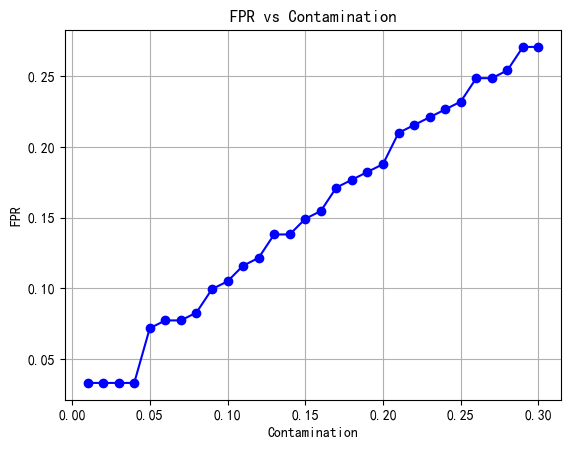

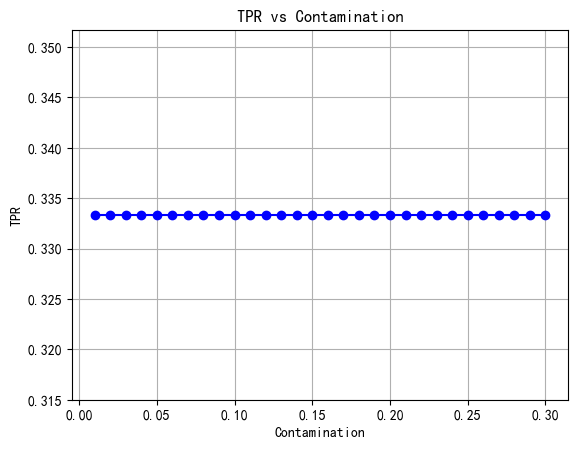

In [166]:
from py2neo import Graph
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import numpy as np

def run_graph_and_detect_anomalies():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })

    contamination_values = np.arange(0.01, 0.31, 0.01)
    fpr_values = []
    tpr_values = []
    
    for contamination in contamination_values:
    # 执行异常检测 (孤立森林)
        all_labels = []
        all_predictions = []
    
        # 遍历每个连通子图并提取数据
        for component_id in component_results:
            data = []
            labels = []
    
            for record in component_results[component_id]:
                ppnode = record['node']
                relationship = record['relationship']
                pnode = record['target_node']
                uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'], relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
                data.append([uid, timestamp, ppcomm, pcomm, ppid, option])
                labels.append(label)
            
            # 将数据转换为 numpy 数组
            data_tmp = data
            data = np.array(data)
    
            # 对 timestamp 进行标准化处理
            scaler = MinMaxScaler()
            data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()
    
            # 将其他特征编码为整数
            le_process = LabelEncoder()
            data[:, 0] = le_process.fit_transform(data[:, 0])
            data[:, 2] = le_process.fit_transform(data[:, 2])
            data[:, 3] = le_process.fit_transform(data[:, 3])
            data[:, 4] = le_process.fit_transform(data[:, 4])
            data[:, 5] = le_process.fit_transform(data[:, 5])
    
            
            # 创建孤立森林模型
            clf = IsolationForest(contamination=contamination, random_state=42)
            clf.fit(data)
    
            # 获取预测结果
            predictions = clf.predict(data)
    
            # 处理异常预测结果
            #for j, pred in enumerate(predictions):
                #if pred == -1:
                    # 找到异常条目
                    #print(f"进程链 {j+1} 可能是入侵")
                    #print(data_tmp[j])
    
            # 更新预测结果
            predictions = [1 if pred == -1 else 0 for pred in predictions]
            all_labels.append(labels)
            all_predictions.append(predictions)

        # 将所有社区的 labels 和 predictions 展开成单个列表
        all_labels = [label for sublist in all_labels for label in sublist]
        all_predictions = [prediction for sublist in all_predictions for prediction in sublist]
    
        # 计算混淆矩阵
        conf_matrix = confusion_matrix(all_labels, all_predictions)
    
        # 从混淆矩阵中提取 TP, TN, FP, FN
        TP = conf_matrix[1, 1]  # 真阳性
        TN = conf_matrix[0, 0]  # 真阴性
        FP = conf_matrix[0, 1]  # 假阳性
        FN = conf_matrix[1, 0]  # 假阴性
        
        # 计算 TPR 和 FPR
        tpr = TP / (TP + FN)  # True Positive Rate (Recall)
        tpr_values.append(tpr)
        fpr = FP / (FP + TN)  # False Positive Rate
        fpr_values.append(fpr)
    
    for i, fpr in enumerate(fpr_values, 1):
        print(f"Contamination: {contamination_values[i-1]:.2f}, FPR: {fpr:.4f}")

    print("-" * 30)

    for i, fpr in enumerate(tpr_values, 1):
        print(f"Contamination: {contamination_values[i-1]:.2f}, TPR: {fpr:.4f}")

    # 绘制 FPR 曲线图
    plt.plot(contamination_values, fpr_values, marker='o', linestyle='-', color='b')
    plt.title('FPR vs Contamination')
    plt.xlabel('Contamination')
    plt.ylabel('FPR')
    plt.grid(True)
    plt.show()

    # 绘制 TPR 曲线图
    plt.plot(contamination_values, tpr_values, marker='o', linestyle='-', color='b')
    plt.title('TPR vs Contamination')
    plt.xlabel('Contamination')
    plt.ylabel('TPR')
    plt.grid(True)
    plt.show()

run_graph_and_detect_anomalies()

## 汇总四个contamination图

- FPR

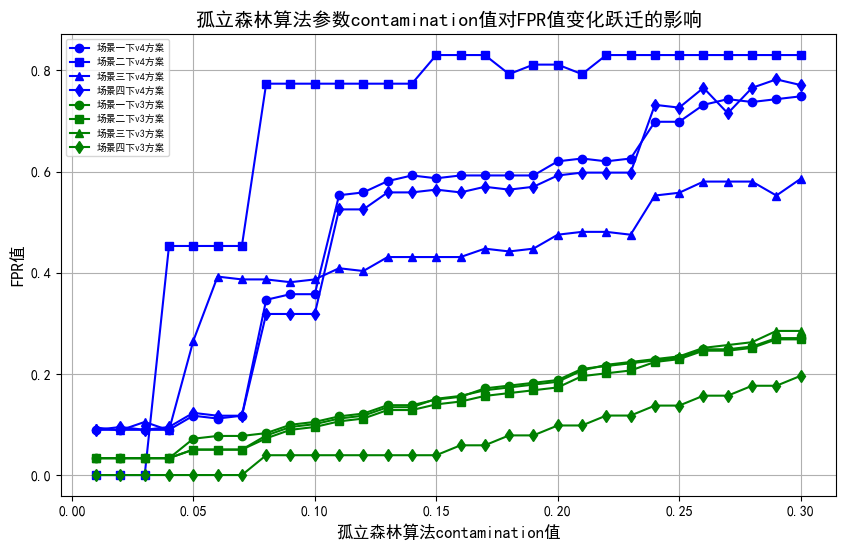

In [230]:
import numpy as np
import matplotlib.pyplot as plt

# 四组数据
contamination_values = np.arange(0.01, 0.31, 0.01)

# 场景1数据 (FPR值)
fpr_scenario1 = [
    0.0894, 0.0894, 0.0894, 0.0894, 0.1173, 0.1117, 0.1173, 0.3464, 0.3575, 0.3575,
    0.5531, 0.5587, 0.5810, 0.5922, 0.5866, 0.5922, 0.5922, 0.5922, 0.5922, 0.6201,
    0.6257, 0.6201, 0.6257, 0.6983, 0.6983, 0.7318, 0.7430, 0.7374, 0.7430, 0.7486
]

# 场景2数据 (FPR值)
fpr_scenario2 = [
    0.0000, 0.0000, 0.0000, 0.4528, 0.4528, 0.4528, 0.4528, 0.7736, 0.7736, 0.7736,
    0.7736, 0.7736, 0.7736, 0.7736, 0.8302, 0.8302, 0.8302, 0.7925, 0.8113, 0.8113,
    0.7925, 0.8302, 0.8302, 0.8302, 0.8302, 0.8302, 0.8302, 0.8302, 0.8302, 0.8302
]

# 场景3数据 (FPR值)
fpr_scenario3 = [
    0.0939, 0.0884, 0.1050, 0.0884, 0.2652, 0.3923, 0.3867, 0.3867, 0.3812, 0.3867,
    0.4088, 0.4033, 0.4309, 0.4309, 0.4309, 0.4309, 0.4475, 0.4420, 0.4475, 0.4751,
    0.4807, 0.4807, 0.4751, 0.5525, 0.5580, 0.5801, 0.5801, 0.5801, 0.5525, 0.5856
]

# 场景4数据 (FPR值)
fpr_scenario4 = [
    0.0894, 0.0950, 0.0894, 0.0950, 0.1229, 0.1173, 0.1173, 0.3184, 0.3184, 0.3184,
    0.5251, 0.5251, 0.5587, 0.5587, 0.5642, 0.5587, 0.5698, 0.5642, 0.5698, 0.5922,
    0.5978, 0.5978, 0.5978, 0.7318, 0.7263, 0.7654, 0.7151, 0.7654, 0.7821, 0.7709
]


# 场景1数据 (FPR值)
fpr_scenario11 = [
    0.0331, 0.0331, 0.0331, 0.0331, 0.0718, 0.0773, 0.0773, 0.0829, 0.0994, 0.1050,
    0.1160, 0.1215, 0.1381, 0.1381, 0.1492, 0.1547, 0.1713, 0.1768, 0.1823, 0.1878,
    0.2099, 0.2155, 0.2210, 0.2265, 0.2320, 0.2486, 0.2486, 0.2541, 0.2707, 0.2707
]

# 场景2数据 (FPR值)
fpr_scenario22 = [
    0.0335, 0.0335, 0.0335, 0.0335, 0.0503, 0.0503, 0.0503, 0.0726, 0.0894, 0.0950,
    0.1061, 0.1117, 0.1285, 0.1285, 0.1397, 0.1453, 0.1564, 0.1620, 0.1676, 0.1732,
    0.1955, 0.2011, 0.2067, 0.2235, 0.2291, 0.2458, 0.2458, 0.2514, 0.2682, 0.2682
]

# 场景3数据 (FPR值)
fpr_scenario33 = [
    0.0335, 0.0335, 0.0335, 0.0335, 0.0503, 0.0503, 0.0503, 0.0782, 0.0950, 0.1006,
    0.1117, 0.1173, 0.1341, 0.1341, 0.1508, 0.1564, 0.1676, 0.1732, 0.1788, 0.1844,
    0.2067, 0.2179, 0.2235, 0.2291, 0.2346, 0.2514, 0.2570, 0.2626, 0.2849, 0.2849
]

# 场景4数据 (FPR值)
fpr_scenario44 = [
    0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0392, 0.0392, 0.0392,
    0.0392, 0.0392, 0.0392, 0.0392, 0.0392, 0.0588, 0.0588, 0.0784, 0.0784, 0.0980,
    0.0980, 0.1176, 0.1176, 0.1373, 0.1373, 0.1569, 0.1569, 0.1765, 0.1765, 0.1961
]


# 绘制图形
plt.figure(figsize=(10, 6))

# 每个场景的数据绘制
plt.plot(contamination_values, fpr_scenario1, marker='o', linestyle='-', color='b', label='场景一下v4方案')
plt.plot(contamination_values, fpr_scenario2, marker='s', linestyle='-', color='b', label='场景二下v4方案')
plt.plot(contamination_values, fpr_scenario3, marker='^', linestyle='-', color='b', label='场景三下v4方案')
plt.plot(contamination_values, fpr_scenario4, marker='d', linestyle='-', color='b', label='场景四下v4方案')

plt.plot(contamination_values, fpr_scenario11, marker='o', linestyle='-', color='g', label='场景一下v3方案')
plt.plot(contamination_values, fpr_scenario22, marker='s', linestyle='-', color='g', label='场景二下v3方案')
plt.plot(contamination_values, fpr_scenario33, marker='^', linestyle='-', color='g', label='场景三下v3方案')
plt.plot(contamination_values, fpr_scenario44, marker='d', linestyle='-', color='g', label='场景四下v3方案')


# 添加标题和标签
plt.title('孤立森林算法参数contamination值对FPR值变化跃迁的影响', fontsize=14)
plt.xlabel('孤立森林算法contamination值', fontsize=12)
plt.ylabel('FPR值', fontsize=12)

# 添加图例
plt.legend(fontsize=7)

# 显示网格
plt.grid(True)

# 显示图形
plt.show()


- TPR

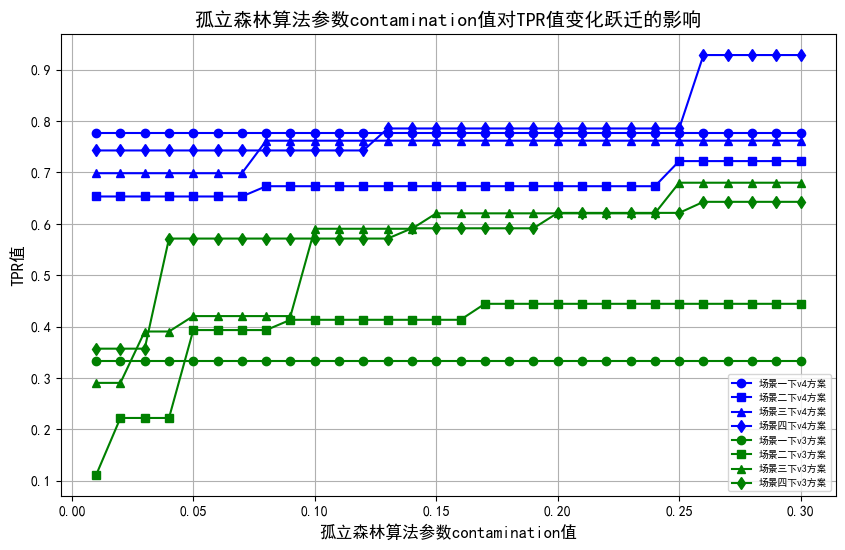

In [229]:
import numpy as np
import matplotlib.pyplot as plt

# 四组新的数据
contamination_values = np.arange(0.01, 0.31, 0.01)


# 四组数据
tpr_scenario1 = [
    0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778,
    0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778,
    0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778
]

tpr_scenario2 = [
    0.6533, 0.6533, 0.6533, 0.6533, 0.6533, 0.6533, 0.6533, 0.6733, 0.6733, 0.6733,
    0.6733, 0.6733, 0.6733, 0.6733, 0.6733, 0.6733, 0.6733, 0.6733, 0.6733, 0.6733,
    0.6733, 0.6733, 0.6733, 0.6733, 0.7222, 0.7222, 0.7222, 0.7222, 0.7222, 0.7222
]

tpr_scenario3 = [
    0.6986, 0.6986, 0.6986, 0.6986, 0.6986, 0.6986, 0.6986, 0.7619, 0.7619, 0.7619,
    0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619,
    0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619, 0.7619
]

tpr_scenario4 = [
    0.7429, 0.7429, 0.7429, 0.7429, 0.7429, 0.7429, 0.7429, 0.7429, 0.7429, 0.7429,
    0.7429, 0.7429, 0.7857, 0.7857, 0.7857, 0.7857, 0.7857, 0.7857, 0.7857, 0.7857,
    0.7857, 0.7857, 0.7857, 0.7857, 0.7857, 0.9286, 0.9286, 0.9286, 0.9286, 0.9286
]

# 场景1数据 (TPR值)
tpr_scenario11 = [
    0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
    0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
    0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333
]

# 场景2数据 (TPR值)
tpr_scenario22 = [
    0.1111, 0.2222, 0.2222, 0.2222, 0.3933, 0.3933, 0.3933, 0.3933, 0.4133, 0.4133,
    0.4133, 0.4133, 0.4133, 0.4133, 0.4133, 0.4133, 0.4444, 0.4444, 0.4444, 0.4444,
    0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444
]

# 场景3数据 (TPR值)
tpr_scenario33 = [
    0.2905, 0.2905, 0.3905, 0.3905, 0.4205, 0.4205, 0.4205, 0.4205, 0.4205, 0.5905,
    0.5905, 0.5905, 0.5905, 0.5905, 0.6205, 0.6205, 0.6205, 0.6205, 0.6205, 0.6205,
    0.6205, 0.6205, 0.6205, 0.6205, 0.6801, 0.6801, 0.6801, 0.6801, 0.6801, 0.6801
]

# 场景4数据 (TPR值)
tpr_scenario44 = [
     0.3571,  0.3571,  0.3571, 0.5714,0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714,
    0.5714, 0.5714, 0.5714, 0.5914, 0.5914, 0.5914, 0.5914, 0.5914, 0.5914, 0.6214,
    0.6214, 0.6214, 0.6214, 0.6214, 0.6214, 0.6429, 0.6429, 0.6429, 0.6429, 0.6429
]

# 绘制图形
plt.figure(figsize=(10, 6))

# 每个场景的数据绘制
plt.plot(contamination_values, tpr_scenario1, marker='o', linestyle='-', color='b', label='场景一下v4方案')
plt.plot(contamination_values, tpr_scenario2, marker='s', linestyle='-', color='b', label='场景二下v4方案')
plt.plot(contamination_values, tpr_scenario3, marker='^', linestyle='-', color='b', label='场景三下v4方案')
plt.plot(contamination_values, tpr_scenario4, marker='d', linestyle='-', color='b', label='场景四下v4方案')

plt.plot(contamination_values, tpr_scenario11, marker='o', linestyle='-', color='g', label='场景一下v3方案')
plt.plot(contamination_values, tpr_scenario22, marker='s', linestyle='-', color='g', label='场景二下v3方案')
plt.plot(contamination_values, tpr_scenario33, marker='^', linestyle='-', color='g', label='场景三下v3方案')
plt.plot(contamination_values, tpr_scenario44, marker='d', linestyle='-', color='g', label='场景四下v3方案')


# 添加标题和标签
plt.title('孤立森林算法参数contamination值对TPR值变化跃迁的影响', fontsize=14)
plt.xlabel('孤立森林算法参数contamination值', fontsize=12)
plt.ylabel('TPR值', fontsize=12)

# 添加图例
plt.legend( fontsize=7)

# 显示网格
plt.grid(True)

# 显示图形
plt.show()


# 扩展窗口共识

In [2]:
from py2neo import Graph, Node, Relationship
from datetime import datetime
import hashlib

# 连接到Neo4j数据库
graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

# 检查图是否存在，如果存在则删除
def check_and_drop_graph(graph_name):
    query = """
        CALL gds.graph.list()
    """
    result = graph.run(query).data()
    existing_graphs = [g['graphName'] for g in result]

    if graph_name in existing_graphs:
        print(f"Graph {graph_name} already exists. Dropping it...")
        query_drop = f"CALL gds.graph.drop('{graph_name}')"
        graph.run(query_drop)

# 删除所有现有节点和关系
def clear_all_data():
    query = """
        MATCH (n) DETACH DELETE n
    """
    graph.run(query)

# 导入数据并创建节点和关系
def import_data(file_path):
    with open(file_path, "r") as file:
        for line in file:
            try:
                # 解析数据行
                data = line.strip().split('"')
                uid, time, child_comm, child_pid, parent_comm, parent_pid, return_code, cmdline, option = data[1], data[3], data[5], data[7], data[9], data[11], data[13], data[15], data[17]
                
                # 转换时间戳
                date_object = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
                timestamp = date_object.timestamp()
                label = int(line.strip()[-1])
                id = str(time) + '-' + str(child_pid)

                # 创建父进程和子进程节点
                parent_process = Node("Process", id=id, pid=parent_pid, name=parent_comm, comm=parent_comm)
                child_process = Node("Process", id=id, pid=child_pid, name=child_comm, comm=child_comm)

                # 创建进程间的关系
                rel = Relationship(parent_process, "create_process", child_process)  # 修改为小写 'create_process'
                rel["uid"] = uid
                rel["time"] = timestamp
                rel["cmdline"] = cmdline
                rel["return"] = return_code
                rel["option"] = option
                rel["label"] = label

                # 使用 graph.merge 来确保节点和关系唯一
                graph.merge(parent_process, "Process", "pid")
                graph.merge(child_process, "Process", "pid")
                graph.merge(rel)
            except Exception as e:
                print(f"Error processing line: {e}")
                continue

# 创建图
def create_graph(graph_name):
    check_and_drop_graph(graph_name)  # 检查并删除已存在的图

    # 创建图时，使用正确的关系类型名称，但不指定任何关系属性
    query = f"""
        CALL gds.graph.project(
            '{graph_name}',
            'Process',
            {{
                create_process: {{
                    orientation: 'UNDIRECTED'
                }}
            }})
    """
    result = graph.run(query).data()
    print("Graph created and data imported into Neo4j.")

# 主流程
def run_graph(file_path):
    graph_name = 'myGraph'

    # 清空现有数据（如果需要）
    clear_all_data()

    # 导入数据
    import_data(file_path)

    # 创建图
    create_graph(graph_name)

In [30]:
run_graph("window.4")

Graph myGraph already exists. Dropping it...
Graph created and data imported into Neo4j.


In [31]:
from py2neo import Graph
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import numpy as np
from sklearn.cluster import KMeans

def run_graph_and_cluster():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 存储所有聚类的结果（包括没有参与聚类的）
    all_clusters = []

    # 遍历每个连通子图并提取数据
    for component_id, nodes_and_relationships in component_results.items():
        data = []  # 存储数据
        original_data = []  # 存储原始数据
        
        for item in nodes_and_relationships:
            ppnode = item['node']
            relationship = item['relationship']
            pnode = item['target_node']
            
            # 从关系中提取信息
            uid = relationship['uid']
            timestamp = relationship['time']
            pcomm = pnode['name']
            ppcomm = ppnode['name']
            ppid = ppnode['pid']
            option = relationship['option']
            
            # 将数据添加到数据列表
            data.append([uid, timestamp])
            original_data.append([uid, timestamp, pcomm, ppcomm, ppid, option])  # 保留原始数据
        
        # 如果该子图的样本数小于 2，则跳过聚类，单独处理
        n_samples = len(data)
        if n_samples < 3:
            all_clusters.append([original_data])  # 将数据放入一个独立的聚类
            continue  # 跳过聚类

        # 将数据转换为 NumPy 数组进行聚类
        data_array = np.array(data)

        # 提取聚类特征：这里使用 uid 和 timestamp 作为聚类特征
        clustering_data = data_array[:, [0, 1]].astype(float)  # 选择 uid 和 timestamp 列

        # 进行 KMeans 聚类
        n_clusters = 3  # 设定默认簇数
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(clustering_data)

        # 存储聚类结果
        clusters = [[] for _ in range(n_clusters)]
        
        for original_item, cluster_label in zip(original_data, cluster_labels):
            clusters[cluster_label].append(original_item)  # 将数据添加到对应的聚类中
        
        # 将聚类结果添加到 all_clusters 中
        all_clusters.append(clusters)

    return all_clusters

def find_similar_entries_in_cluster(entry, all_clusters):
    """
    给定一个条目，查找该条目所在的聚类并返回该聚类中的其他条目。

    :param entry: 条目，格式为 [timestamp, uid, ppcomm, pcomm, ppid, option]
    :param all_clusters: 所有聚类的结果
    :return: 该条目所在聚类的其他条目
    """
    # 遍历所有聚类，寻找给定条目所在的聚类
    for clusters in all_clusters:
        for cluster in clusters:
            # 检查当前条目是否在该聚类中
            if entry in cluster:
                # 返回该聚类中所有条目，排除掉当前条目
                return [item for item in cluster if item != entry]
    
    # 如果条目未找到，返回空列表
    return []

def run_graph_and_detect_anomalies():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 执行异常检测 (孤立森林)
    all_labels = []
    all_predictions = []
    all_clusters = []  # 存储聚类结果

    # 遍历每个连通子图并提取数据
    for component_id in component_results:
        data = []
        labels = []

        for record in component_results[component_id]:
            ppnode = record['node']
            relationship = record['relationship']
            pnode = record['target_node']
            uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'], relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
            data.append([uid, timestamp, pcomm, ppcomm, ppid, option])
            labels.append(label)
        
        # 将数据转换为 numpy 数组
        data_tmp = data
        data = np.array(data)

        # 对 timestamp 进行标准化处理
        scaler = MinMaxScaler()
        data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()

        # 将其他特征编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])
        data[:, 4] = le_process.fit_transform(data[:, 4])
        data[:, 5] = le_process.fit_transform(data[:, 5])

        # 创建孤立森林模型
        clf = IsolationForest(contamination=0.05, random_state=42)
        clf.fit(data)

        # 获取预测结果
        predictions = clf.predict(data)
      
        # 运行聚类函数
        all_clusters = run_graph_and_cluster()
        
        # 处理异常预测结果
        for j, pred in enumerate(predictions):
            if pred == -1:
                # 找到异常条目
                print(f"进程链 {j+1} 可能是入侵")
                print(data_tmp[j])

                # 查找异常条目所在的聚类并输出其他条目
                similar_entries = find_similar_entries_in_cluster(data_tmp[j], all_clusters)
                #print("与此异常条目关联的其他条目：")
                #for entry in similar_entries:
                    #print(entry)

                # 标记聚类中的其他条目为异常
                for entry in similar_entries:
                    idx = data_tmp.index(entry)
                    predictions[idx] = -1  # 将关联条目标记为异常

        # 更新预测结果
        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_labels.append(labels)
        all_predictions.append(predictions)

    # 将所有社区的 labels 和 predictions 展开成单个列表
    all_labels = [label for sublist in all_labels for label in sublist]
    all_predictions = [prediction for sublist in all_predictions for prediction in sublist]

    # 计算混淆矩阵
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # 从混淆矩阵中提取 TP, TN, FP, FN
    TP = conf_matrix[1, 1]  # 真阳性
    TN = conf_matrix[0, 0]  # 真阴性
    FP = conf_matrix[0, 1]  # 假阳性
    FN = conf_matrix[1, 0]  # 假阴性
    
    # 计算 TPR 和 FPR
    TPR = TP / (TP + FN)  # True Positive Rate (Recall)
    FPR = FP / (FP + TN)  # False Positive Rate
    
    # 输出结果
    print(f"True Positive Rate (TPR): {TPR:.2f}")
    print(f"False Positive Rate (FPR): {FPR:.2f}")
    
    # 计算其他评估指标
    precision = accuracy_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    
    print("Accuracy:", accuracy)
    print("Precision：", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


In [32]:
run_graph_and_detect_anomalies()

进程链 3 可能是入侵
['0', 1698666101.0, 'ping', 'bash', '35973', '网络请求操作']
进程链 4 可能是入侵
['0', 1698666092.0, 'docker', 'bash', '35973', '容器操作']
进程链 5 可能是入侵
['0', 1698666080.0, 'ifconfig', 'bash', '35973', '网络信息查看操作']
进程链 12 可能是入侵
['0', 1698651706.0, 'bash', 'runc', '40999', 'bash创建操作']
进程链 13 可能是入侵
['0', 1698651706.0, 'exe', 'runc', '40999', '系统操作']
进程链 3 可能是入侵
['0', 1698651247.0, 'sleep', 'bash', '40389', '系统操作']
进程链 13 可能是入侵
['0', 1698651330.0, 'git-remote-http', 'git', '40888', '版本控制操作']
进程链 1 可能是入侵
['0', 1698565036.0, 'ping', 'java', '39367', '网络请求操作']
进程链 2 可能是入侵
['1', 1698838385.0, 'ps', 'ruby2.7', '112368', '进程操作']
进程链 3 可能是入侵
['1', 1698838382.0, 'ps', 'ruby2.7', '112368', '进程操作']
进程链 5 可能是入侵
['1000', 1698751949.0, 'ps', 'gitaly', '112365', '进程操作']
进程链 6 可能是入侵
['1000', 1698751949.0, 'ps', 'gitaly', '112365', '进程操作']
进程链 9 可能是入侵
['1001', 1698924610.0, 'touch', 'exiftool', '112898', '文件创建操作']
进程链 14 可能是入侵
['1001', 1698924610.0, 'ping', 'exiftool', '113077', '网络请求操作']
进程链 15 可能是入侵
['1001', 1

In [6]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix
from py2neo import Graph
from sklearn.cluster import KMeans

# 屏蔽 ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# 连接到Neo4j数据库
graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

# 查询所有连通子图的 componentId 和节点的关系
def get_connected_components():
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()
    return result



def run_graph_and_cluster():
    # 连接到 Neo4j 图数据库
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    # 查询所有连通子图的 componentId 和节点的关系
    query = """
        CALL gds.wcc.stream('myGraph')
        YIELD nodeId, componentId
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN componentId, n, r, m
        ORDER BY componentId ASC
    """  
    result = graph.run(query).data()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 存储所有聚类的结果（包括没有参与聚类的）
    all_clusters = []

    # 遍历每个连通子图并提取数据
    for component_id, nodes_and_relationships in component_results.items():
        data = []  # 存储数据
        original_data = []  # 存储原始数据
        
        for item in nodes_and_relationships:
            ppnode = item['node']
            relationship = item['relationship']
            pnode = item['target_node']
            
            # 从关系中提取信息
            uid = relationship['uid']
            timestamp = relationship['time']
            pcomm = pnode['name']
            ppcomm = ppnode['name']
            ppid = ppnode['pid']
            option = relationship['option']
            
            # 将数据添加到数据列表
            data.append([uid, timestamp])
            original_data.append([uid, timestamp, pcomm, ppcomm, ppid, option])  # 保留原始数据
        
        # 如果该子图的样本数小于 2，则跳过聚类，单独处理
        n_samples = len(data)
        if n_samples < 3:
            all_clusters.append([original_data])  # 将数据放入一个独立的聚类
            continue  # 跳过聚类

        # 将数据转换为 NumPy 数组进行聚类
        data_array = np.array(data)

        # 提取聚类特征：这里使用 uid 和 timestamp 作为聚类特征
        clustering_data = data_array[:, [0, 1]].astype(float)  # 选择 uid 和 timestamp 列

        # 进行 KMeans 聚类
        n_clusters = 3  # 设定默认簇数
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(clustering_data)

        # 存储聚类结果
        clusters = [[] for _ in range(n_clusters)]
        
        for original_item, cluster_label in zip(original_data, cluster_labels):
            clusters[cluster_label].append(original_item)  # 将数据添加到对应的聚类中
        
        # 将聚类结果添加到 all_clusters 中
        all_clusters.append(clusters)

    return all_clusters

# 查找与异常条目相似的其他条目（聚类相关）
def find_similar_entries_in_cluster(entry, all_clusters):
    similar_entries = []
    for cluster in all_clusters:
        if entry in cluster:  # 假设所有条目都在对应的聚类中
            similar_entries.extend(cluster)
    return similar_entries

# 执行图数据库查询并进行异常检测
def run_graph_and_detect_anomalies():
    result = get_connected_components()

    # 按 componentId 分组
    component_results = {}
    for record in result:
        component_id = record['componentId']
        if component_id not in component_results:
            component_results[component_id] = []
        component_results[component_id].append({
            'node': record['n'],
            'relationship': record['r'],
            'target_node': record['m']
        })
    
    # 执行异常检测
    all_labels = []
    all_predictions = []
    all_clusters = []  # 存储聚类结果

    # 遍历每个连通子图并提取数据
    for component_id in component_results:
        data = []
        labels = []

        for record in component_results[component_id]:
            ppnode = record['node']
            relationship = record['relationship']
            pnode = record['target_node']
            uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'], relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
            data.append([uid, timestamp, pcomm, ppcomm, ppid, option])
            labels.append(label)
        
        # 将数据转换为 numpy 数组
        data_tmp = data
        data = np.array(data)

        # 对 timestamp 进行标准化处理
        scaler = MinMaxScaler()
        data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()

        # 将其他特征编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])
        data[:, 4] = le_process.fit_transform(data[:, 4])
        data[:, 5] = le_process.fit_transform(data[:, 5])

        # 创建孤立森林模型
        clf = IsolationForest(contamination=0.05, random_state=42)
        clf.fit(data)

        # 获取预测结果
        predictions = clf.predict(data)

        # 运行聚类函数
        all_clusters = run_graph_and_cluster()
        
        # 处理异常预测结果
        for j, pred in enumerate(predictions):
            if pred == -1:
                # 找到异常条目
                print(f"进程链 {j+1} 可能是入侵")
                print(data_tmp[j])

                # 查找异常条目所在的聚类并输出其他条目
                similar_entries = find_similar_entries_in_cluster(data_tmp[j], all_clusters)
                print("与此异常条目关联的其他条目：")
                for entry in similar_entries:
                    print(entry)

                # 标记聚类中的其他条目为异常
                for entry in similar_entries:
                    idx = data_tmp.index(entry)
                    predictions[idx] = -1  # 将关联条目标记为异常

        # 更新预测结果
        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_predictions.extend(predictions)  # 保存所有预测结果
        all_labels.extend(labels)  # 保存所有标签

    return all_labels, all_predictions

# 统计重复的异常条目
def find_repeated_anomalies(all_anomalies):
    anomaly_counter = Counter(tuple(entry) for entry in all_anomalies)
    repeated_anomalies = [entry for entry, count in anomaly_counter.items() if count > 1]
    return repeated_anomalies

# 主流程：对五个文件进行处理并进行评估
def run_full_detection():
    all_detected_anomalies = []

    # 五次检测
    for i in range(1, 6):
        print(f"Processing window.{i}...")
        
        # 导入数据并创建图
        file_path = f"window.{i}"  # 文件路径
        clear_all_data()  # 清空数据库中的数据
        data = import_data(file_path)  # 导入数据
        create_graph(f"graph_{i}")  # 创建图
        
        # 执行异常检测
        labels, predictions = run_graph_and_detect_anomalies()

        # 保存检测到的异常
        all_detected_anomalies.extend([data[i] for i in range(len(predictions)) if predictions[i] == 1])

    # 找到重复出现的异常条目
    repeated_anomalies = find_repeated_anomalies(all_detected_anomalies)

    # 获取第5次的标签
    file_path = "window.5"  # 第5次文件
    data_5 = import_data(file_path)
    true_labels = [entry[-1] for entry in data_5]  # 提取第5次的真实标签

    # 使用重复异常条目与第5次标签进行对比
    predictions = [1 if tuple(entry) in repeated_anomalies else 0 for entry in all_detected_anomalies]
    conf_matrix = confusion_matrix(true_labels, predictions)

    TP = conf_matrix[1, 1]  # 真阳性
    TN = conf_matrix[0, 0]  # 真阴性
    FP = conf_matrix[0, 1]  # 假阳性
    FN = conf_matrix[1, 0]  # 假阴性

    TPR = TP / (TP + FN)  # True Positive Rate (Recall)
    FPR = FP / (FP + TN)  # False Positive Rate
    
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print(f"True Positive Rate (TPR): {TPR:.2f}")
    print(f"False Positive Rate (FPR): {FPR:.2f}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

# 调用主流程
run_full_detection()


Processing window.1...
Graph graph_1 already exists. Dropping it...
Graph created and data imported into Neo4j.
Processing window.2...
Error processing line: list index out of range
Graph graph_2 already exists. Dropping it...
Graph created and data imported into Neo4j.
进程链 50 可能是入侵
['0', 1698751801.0, 'sh', 'cron', '112873', '计划任务操作']
与此异常条目关联的其他条目：
进程链 51 可能是入侵
['0', 1698751807.0, 'sleep', 'bash', '106642', '系统操作']
与此异常条目关联的其他条目：
进程链 59 可能是入侵
['1000', 1698751810.0, 'touch', 'exiftool', '112898', '文件创建操作']
与此异常条目关联的其他条目：
进程链 62 可能是入侵
['1000', 1698751843.0, 'ls', 'exiftool', '112954', '查看目录操作']
与此异常条目关联的其他条目：


TypeError: 'NoneType' object is not subscriptable

## 滑动窗口大小确定

In [111]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

file_path = "command.data"
# 读取数据
data = []
labels = []
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline_type = parts[1], parts[3], parts[5], parts[9], parts[11], parts[17]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline_type])
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 处理时间戳：将字符串日期转化为Unix时间戳
def convert_to_unix_timestamp(date_str):
    try:
        dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')  # 这里的格式要与数据中的时间格式一致
        return dt.timestamp()  # 返回Unix时间戳
    except ValueError:
        return 0  # 如果无法转换，则返回0

# 将时间戳转换为Unix时间戳
data[:, 1] = np.array([convert_to_unix_timestamp(ts) for ts in data[:, 1]])

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])
data[:, 5] = le_process.fit_transform(data[:, 5])

# 打印出每列的数据类型，以便检查哪些列仍然是字符串类型
for idx, column in enumerate(data.T):  # 转置后遍历每列
    print(f"Column {idx}: dtype={column.dtype}")

# 如果仍有列为字符串类型，可以强制转换为浮动类型
data = data.astype(float)  # 强制将数据转为数值类型

# 提取时间并归一化处理
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()  # 时间戳进行归一化处理

# 确保数据是数值类型
print(f"Data type after conversion: {data.dtype}")  # 再次打印出数据类型确认

# 定义 get_pr 函数
def get_pr(pos_prob, y_true):
    pos = y_true[y_true == 1]
    sorted_indices = np.argsort(pos_prob)[::-1]
    threshold = pos_prob[sorted_indices]
    y = y_true[sorted_indices]
    recall = []
    precision = []
    tp = 0
    fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        recall.append(tp / len(pos))
        precision.append(tp / (tp + fp))
        if i > 0:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

# 假设我们给每个特征一个不同的权重，以下是一个简单的例子
weighted_features = np.array([1.0, 1.0, 2.0, 2.0, 2.0, 2.0])  # 各特征的权重

# 打印一下数据的部分内容，确认没有问题
print(data[:5])  # 打印前5行数据查看

# 设置不同的 contamination 值
contamination_values = [0.05]

# 自定义加权孤立森林模型
class WeightedIsolationForest(IsolationForest):
    def __init__(self, n_estimators=100, contamination='auto', max_samples='auto', random_state=None, weighted_features=None):
        super().__init__(n_estimators=n_estimators, contamination=contamination, max_samples=max_samples, random_state=random_state)
        self.weighted_features = weighted_features  # 用于存储每个特征的权重

    def fit(self, X, y=None):
        if self.weighted_features is not None:
            # 对数据应用特征权重
            weighted_X = X * self.weighted_features
        else:
            weighted_X = X
        return super().fit(weighted_X)

# 遍历不同的 contamination 值
for contamination in contamination_values:
    # 创建并训练加权孤立森林模型
    clf = WeightedIsolationForest(contamination=contamination, random_state=42, weighted_features=weighted_features)
    clf.fit(data)  # 现在所有数据已经是数值型了，能成功进行训练
    
    # 获取预测结果
    predictions = clf.predict(data)
    predictions = [1 if pred == -1 else 0 for pred in predictions]  # -1代表异常，转换为1
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    # 计算TPR（Recall）和FPR
    tpr = tp / (tp + fn)  # 真正例率（Recall）
    fpr = fp / (fp + tn)  # 假正例率

    # 计算 Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

    # 计算 F1 Score
    f1 = f1_score(labels, predictions)

    # 计算Accuracy
    accuracy = accuracy_score(labels, predictions)

    # 获取异常分数（用于PR曲线）
    anomaly_scores = -clf.decision_function(data)  # 异常分数越高，表示越可能是异常

    # 计算PR曲线和AUC-PR
    precision_list_2, recall_list_2, auc_pr_2 = get_pr(anomaly_scores, np.array(labels))

    # 打印结果
    print(f"Contamination={contamination}:")
    print(f"  Recall (TPR) = {tpr:.2f}")
    print(f"  Precision = {precision:.2f}")
    print(f"  FPR = {fpr:.2f}")
    print(f"  F1 Score = {f1:.2f}")
    print(f"  Accuracy = {accuracy:.2f}")
    print(f"  AUC-PR = {auc_pr_2:.2f}")
    print("-" * 30)


Column 0: dtype=<U19
Column 1: dtype=<U19
Column 2: dtype=<U19
Column 3: dtype=<U19
Column 4: dtype=<U19
Column 5: dtype=<U19
Data type after conversion: float64
[[0.00000000e+00 0.00000000e+00 1.70000000e+01 0.00000000e+00
  1.00000000e+01 1.10000000e+01]
 [0.00000000e+00 2.77885101e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 5.55770112e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 8.33655213e-06 1.70000000e+01 0.00000000e+00
  2.10000000e+01 9.00000000e+00]
 [0.00000000e+00 3.05673584e-05 1.70000000e+01 0.00000000e+00
  1.30000000e+01 1.40000000e+01]]
Contamination=0.05:
  Recall (TPR) = 0.45
  Precision = 0.83
  FPR = 0.01
  F1 Score = 0.58
  Accuracy = 0.93
  AUC-PR = 0.55
------------------------------


## 不同方案的对比

### knn

In [85]:
file_path = "command.data"

In [86]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer  # 用于处理文本特征
from datetime import datetime
import matplotlib.pyplot as plt  # 导入绘图库

# 读取数据
data = []
labels = []
cmdline_data = []  # 仅保存cmdline数据
with open(file_path, "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, pcomm, ppcomm, ppid, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
            data.append([uid, timestamp, ppid, ppcomm, pcomm, cmdline])
            cmdline_data.append(cmdline)  # 保存cmdline列
        labels.append(int(line.strip()[-1]))  # 使用最后一位作为标签

# 转换为numpy数组
data = np.array(data)

# 将cmdline进行文本向量化
vectorizer = TfidfVectorizer(max_features=100)  # 限制最大特征数为100，可以根据需求调整
cmdline_features = vectorizer.fit_transform(cmdline_data).toarray()  # 将cmdline转换为特征向量

# 将特征和标签转为numpy数组
cmdline_features = np.array(cmdline_features)

# 设置KNN模型
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')

# 训练KNN模型
knn.fit(cmdline_features, labels)

# 获取预测结果
predictions = knn.predict(cmdline_features)

# 计算混淆矩阵
tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

# 计算TPR（Recall）和FPR
tpr = tp / (tp + fn)  # 真正例率（Recall）
fpr = fp / (fp + tn)  # 假正例率

# 计算 Precision
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 避免除零错误

# 计算 F1 Score
f1 = f1_score(labels, predictions)

# 计算Accuracy
accuracy = accuracy_score(labels, predictions)

# 打印结果
print(f"KNN Results (Using cmdline only):")
print(f"  Recall (TPR) = {tpr:.2f}")
print(f"  Precision = {precision:.2f}")
print(f"  FPR = {fpr:.2f}")
print(f"  F1 Score = {f1:.2f}")
print(f"  Accuracy = {accuracy:.2f}")
print("-" * 30)


KNN Results (Using cmdline only):
  Recall (TPR) = 0.82
  Precision = 0.88
  FPR = 0.01
  F1 Score = 0.85
  Accuracy = 0.97
------------------------------


### hmm

In [90]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# 生成模拟数据集A
def generate_data(n_samples=1000, n_features=5, anomaly_rate=0.1):
    """
    生成数据集A，其中包括正常数据和异常数据。
    n_samples: 样本总数
    n_features: 每个样本的特征数量
    anomaly_rate: 异常数据的比例
    """
    # 正常数据（标签为0）
    normal_data = np.random.normal(loc=0.0, scale=1.0, size=(int(n_samples * (1 - anomaly_rate)), n_features))
    normal_labels = [0] * len(normal_data)
    
    # 异常数据（标签为1）
    anomaly_data = np.random.normal(loc=5.0, scale=1.0, size=(int(n_samples * anomaly_rate), n_features))  # 假设异常数据远离正常数据
    anomaly_labels = [1] * len(anomaly_data)
    
    # 合并数据和标签
    data = np.vstack([normal_data, anomaly_data])
    labels = normal_labels + anomaly_labels
    return data, labels

# 生成数据集A（假设1000个样本，10%为异常）
data_A, labels_A = generate_data(n_samples=1000, anomaly_rate=0.1)

# 生成数据集B（可以模拟一些特征不同的数据）
data_B, labels_B = generate_data(n_samples=1000, anomaly_rate=0.1)

# 假设只用正常数据训练HMM模型
train_data_A = data_A[np.array(labels_A) == 0]

# 用HMM训练数据
model = hmm.GaussianHMM(n_components=3, covariance_type="full", random_state=42)
model.fit(train_data_A)  # 只用数据集A中的正常数据

# 在数据集A上进行测试
logprob_A = model.score_samples(data_A)  # 获取每个样本的log概率值
threshold_A = np.percentile(logprob_A, 50)  # 使用中位数作为阈值

# 对数据进行预测：log概率低于阈值的视为异常（1），其他为正常（0）
predictions_A = [1 if prob < threshold_A else 0 for prob in logprob_A]

# 计算评价指标
accuracy_A = accuracy_score(labels_A, predictions_A)
precision_A = precision_score(labels_A, predictions_A)
recall_A = recall_score(labels_A, predictions_A)
f1_A = f1_score(labels_A, predictions_A)

# 在数据集B上进行测试
logprob_B = model.score_samples(data_B)  # 获取每个样本的log概率值
threshold_B = np.percentile(logprob_B, 50)  # 使用中位数作为阈值

# 对数据进行预测：log概率低于阈值的视为异常（1），其他为正常（0）
predictions_B = [1 if prob < threshold_B else 0 for prob in logprob_B]

# 计算评价指标
accuracy_B = accuracy_score(labels_B, predictions_B)
precision_B = precision_score(labels_B, predictions_B)
recall_B = recall_score(labels_B, predictions_B)
f1_B = f1_score(labels_B, predictions_B)

# 输出结果
print("Results for DataSet A:")
print(f"Accuracy: {accuracy_A:.2f}")
print(f"Precision: {precision_A:.2f}")
print(f"Recall: {recall_A:.2f}")
print(f"F1 Score: {f1_A:.2f}")

print("-" * 30)

print("Results for DataSet B:")
print(f"Accuracy: {accuracy_B:.2f}")
print(f"Precision: {precision_B:.2f}")
print(f"Recall: {recall_B:.2f}")
print(f"F1 Score: {f1_B:.2f}")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.